<a href="https://colab.research.google.com/github/LorenzoTarricone/Compressed-Sensing-to-Pooling-and-Deconvolution-of-Pd-Catalyzed-Cross-Coupling-Reactions-Experiments/blob/main/Python%20Notebooks/SpotfireProcessing_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONTENT

Implementation of the final verison of the code that will be used a Python Datafunction in Spotfire. The most recent version (with also the implementation of the chemical prior) is at the bottom)

In [ ]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#helper function for visualization
def visualize_plate_mixture(array, title = None):

  fig, ax = plt.subplots(figsize=(10, 6))
  cax = ax.imshow(array, aspect='auto')

  # Add colorbar
  fig.colorbar(cax, ax=ax)

  # Add titles
  if title is None:
    ax.set_title("Custom Visualization")
  else:
    ax.set_title(title)


  # Add x and y labels
  ax.set_ylabel('Solvents/bases')
  ax.set_xlabel('Catalysts')

  # names = ['mixture 1', 'mixture 2', 'mixture 3', 'mixture 4', 'mixture 5', 'mixture 6', 'mixture 7',  'mixture 8', 'mixture 9', 'mixture 10', 'mixture 11', 'mixture 12'  ]
  ax.set_xticks(np.arange(array.shape[1]))
  # ax.set_xticklabels(names, rotation=90)

  #write the values of the array inside the array itslelf in white
  for i in range(len(array)):
    for j in range(len(array[0])):
      ax.text(j, i, round(array[i, j], 2), ha="center", va="center", color="white")


  plt.show()


In [ ]:
data_raw = pd.read_table('/content/drive/MyDrive/Catalyst Mixing/Lorenzo - Data (plates from Spotfire) /Copy of Plate_20_1_7.csv', encoding='utf-16', sep=",")

In [ ]:
data_raw

,Coordinate,PLATENUMBER,PlateRow,PlateColumn,Reaction Type,"Bases, all Component","Catalysts, all Component",SAMPLENUMBER,AREA_BP,AREA_TOTAL,Yield,AREA_TOTAL_REDUCED
0,B2,20,B,2,Buchwald-Hartwig,NaOtBu,TrixiePhos Pd G3,1.0,33.43,11.82,0.050814,18.285891
1,D2,20,D,2,Buchwald-Hartwig,NaOtBu,RuPhos Pd(crotyl)Cl,1.0,100.00,16.53,0.222125,18.637953
2,A2,20,A,2,Buchwald-Hartwig,NaOtBu,meCgPPh Pd G3,1.0,100.00,19.51,0.251822,22.112660
3,C2,20,C,2,Buchwald-Hartwig,NaOtBu,Pd-PEPPSI-IPent Cl o-picoline,1.0,82.05,11.90,0.136391,13.719160
4,G2,20,G,2,Buchwald-Hartwig,NaOtBu,TrixiePhos Pd G3,1.0,43.67,6.08,0.066378,7.063197
...,...,...,...,...,...,...,...,...,...,...,...,...
137,D7,20,D,7,Buchwald-Hartwig,KOH,TrixiePhos Pd G3,NaN,NaN,NaN,0.000000,0.000000
138,G1,20,G,1,Buchwald-Hartwig,KOH,TrixiePhos Pd G3,NaN,NaN,NaN,0.000000,0.000000
139,A4,20,A,4,Buchwald-Hartwig,Cs2CO3,meCgPPh Pd G3,NaN,NaN,NaN,0.000000,0.000000
140,E7,20,E,7,Buchwald-Hartwig,KOH,Pd-PEPPSI-IPent Cl o-picoline,NaN,NaN,NaN,0.000000,0.000000


In [ ]:
#assuming that all the lines with N.A.s are non-inportant lines where the yield is zero
df_not_nans = data_raw.dropna()

In [ ]:
df_not_nans

,Coordinate,PLATENUMBER,PlateRow,PlateColumn,Reaction Type,"Bases, all Component","Catalysts, all Component",SAMPLENUMBER,AREA_BP,AREA_TOTAL,Yield,AREA_TOTAL_REDUCED
0,B2,20,B,2,Buchwald-Hartwig,NaOtBu,TrixiePhos Pd G3,1.0,33.43,11.82,0.050814,18.285891
1,D2,20,D,2,Buchwald-Hartwig,NaOtBu,RuPhos Pd(crotyl)Cl,1.0,100.00,16.53,0.222125,18.637953
2,A2,20,A,2,Buchwald-Hartwig,NaOtBu,meCgPPh Pd G3,1.0,100.00,19.51,0.251822,22.112660
3,C2,20,C,2,Buchwald-Hartwig,NaOtBu,Pd-PEPPSI-IPent Cl o-picoline,1.0,82.05,11.90,0.136391,13.719160
4,G2,20,G,2,Buchwald-Hartwig,NaOtBu,TrixiePhos Pd G3,1.0,43.67,6.08,0.066378,7.063197
...,...,...,...,...,...,...,...,...,...,...,...,...
92,G12,20,G,12,Buchwald-Hartwig,KOtBu,RockPhos Pd G6 Br,2.0,24.46,4.73,0.037179,5.862667
93,A12,20,A,12,Buchwald-Hartwig,KOtBu,RuPhos Pd(crotyl)Cl,2.0,70.81,10.60,0.110425,12.410725
94,C12,20,C,12,Buchwald-Hartwig,KOtBu,meCgPPh Pd G3,2.0,11.09,1.22,0.047200,2.992765
95,C12,20,C,12,Buchwald-Hartwig,KOtBu,meCgPPh Pd G3,2.0,13.78,1.51,0.047200,2.992765


In [ ]:
#the column PlateRow has letters from A to H, transform it in numbers form 1 to 8 because needed for indexing

mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}
df_not_nans['PlateRow'] = df_not_nans['PlateRow'].map(mapping)
df_not_nans

/tmp/ipython-input-2788270313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_nans['PlateRow'] = df_not_nans['PlateRow'].map(mapping)


,Coordinate,PLATENUMBER,PlateRow,PlateColumn,Reaction Type,"Bases, all Component","Catalysts, all Component",SAMPLENUMBER,AREA_BP,AREA_TOTAL,Yield,AREA_TOTAL_REDUCED
0,B2,20,2,2,Buchwald-Hartwig,NaOtBu,TrixiePhos Pd G3,1.0,33.43,11.82,0.050814,18.285891
1,D2,20,4,2,Buchwald-Hartwig,NaOtBu,RuPhos Pd(crotyl)Cl,1.0,100.00,16.53,0.222125,18.637953
2,A2,20,1,2,Buchwald-Hartwig,NaOtBu,meCgPPh Pd G3,1.0,100.00,19.51,0.251822,22.112660
3,C2,20,3,2,Buchwald-Hartwig,NaOtBu,Pd-PEPPSI-IPent Cl o-picoline,1.0,82.05,11.90,0.136391,13.719160
4,G2,20,7,2,Buchwald-Hartwig,NaOtBu,TrixiePhos Pd G3,1.0,43.67,6.08,0.066378,7.063197
...,...,...,...,...,...,...,...,...,...,...,...,...
92,G12,20,7,12,Buchwald-Hartwig,KOtBu,RockPhos Pd G6 Br,2.0,24.46,4.73,0.037179,5.862667
93,A12,20,1,12,Buchwald-Hartwig,KOtBu,RuPhos Pd(crotyl)Cl,2.0,70.81,10.60,0.110425,12.410725
94,C12,20,3,12,Buchwald-Hartwig,KOtBu,meCgPPh Pd G3,2.0,11.09,1.22,0.047200,2.992765
95,C12,20,3,12,Buchwald-Hartwig,KOtBu,meCgPPh Pd G3,2.0,13.78,1.51,0.047200,2.992765


In [ ]:
# prompt: make all the entries of column SAMPLENUMBER of type int

df_not_nans['SAMPLENUMBER'] = df_not_nans['SAMPLENUMBER'].astype(int)

/tmp/ipython-input-2828941506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_nans['SAMPLENUMBER'] = df_not_nans['SAMPLENUMBER'].astype(int)


In [ ]:
#Get the maximum number of timepoints present
max_time = np.max(df_not_nans['SAMPLENUMBER'].unique())

In [ ]:
#initialize array for storing resutls
final_array = np.zeros((8, 12, max_time))

In [ ]:
for index, row in df_not_nans.iterrows():
  final_array[row['PlateRow']-1, row['PlateColumn']-1 ,row['SAMPLENUMBER']-1] = row['AREA_TOTAL_REDUCED']

In [ ]:
#time correction: for each condition and each mixture combination, if there is another timepoint with a value different than zero, it uses that.
#This is due to the fact that sometimes we see some yield that at a following timestep disappears, which is not possible of course and is an error of the measuring robot we need to correct for.

for t in range(1,max_time):
  for i in range(final_array.shape[0]):
    for j in range(final_array.shape[1]):
      if final_array[i,j,t] == 0 and final_array[i,j,t-1] != 0:
        final_array[i,j,t] = final_array[i,j,t-1]


In [ ]:
#now we can decide to to the max or the average of all timepoints, we decide to do the average
final_array = np.mean(final_array, axis=2)

In [ ]:
final_array

array([[ 0.        , 24.44136047, 30.4132055 ,  0.        ,  0.        ,
         4.4855846 ,  0.        ,  4.58518493, 12.40898129,  0.        ,
         0.        , 12.37812898],
       [ 0.        , 18.28589079,  2.77731985,  0.        ,  0.        ,
         0.88736393,  0.        , 17.07811071, 11.03051487,  0.        ,
         0.        ,  9.53922084],
       [ 0.        , 13.38006813, 12.01797611,  0.        ,  2.62397979,
        10.31866722,  0.70123004,  5.60131826,  6.10647331,  1.40677411,
         2.47331588,  1.49638238],
       [ 0.        , 19.08557517, 18.02440779,  0.        ,  0.        ,
         3.27052966,  0.        ,  7.43801673, 12.20793353,  0.        ,
         0.        ,  5.4750288 ],
       [ 0.        ,  3.03723529,  3.02246593,  0.        ,  0.        ,
         1.78409097,  0.        , 14.5684118 ,  7.72154306,  0.        ,
         0.        ,  9.42431023],
       [ 0.        ,  5.02103725,  9.59932449,  0.        ,  0.        ,
         0.79790199,  

In [ ]:
reshaped_plate_20 = np.concatenate((final_array[:,:6], final_array[:7,6:]), axis=0).T

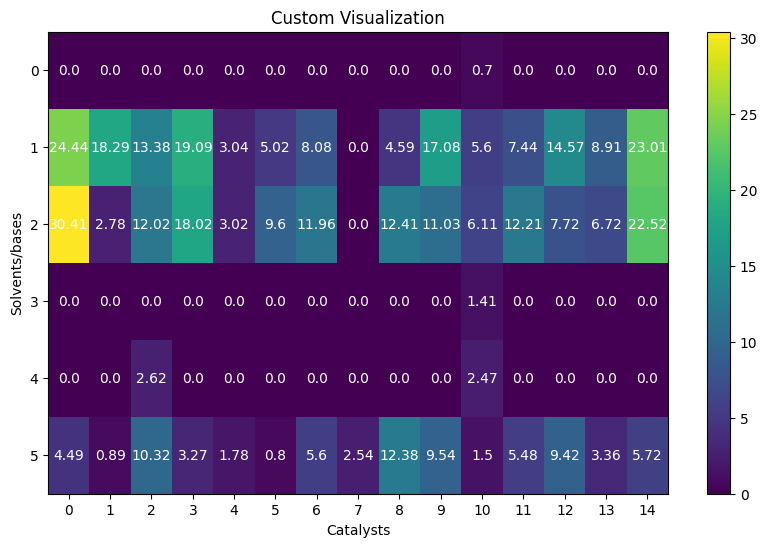

In [ ]:
visualize_plate_mixture(reshaped_plate_20)

In [ ]:
#select a tollerance of number of yields that can be differnet from zero across ligands for a given solvent/base condition and select all the conditions that have produced significan yuield across all experiments
toll_exp = 6
indices_to_keep = []
for i in range(reshaped_plate_20.shape[0]):
  if np.sum(reshaped_plate_20[i,:] > 0) > toll_exp:
    indices_to_keep.append(i)

print("Indices to keep: ", indices_to_keep)


Indices to keep:  [1, 2, 5]


In [ ]:
y_averaged_signal = np.mean(reshaped_plate_20[indices_to_keep,:], axis=0)

In [ ]:
y_averaged_signal

array([19.78005019,  7.31685819, 11.90557048, 13.46017087,  2.6145974 ,
        5.13942124,  8.54718258,  0.84534524,  9.79076506, 12.54928214,
        4.40139132,  8.37365969, 10.57142169,  6.33116635, 17.08328302])

In [ ]:
M = np.array([[1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0],
              [0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0],
              [0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0],
              [0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0],
              [0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0],
              [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1],
              [0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1],
              [0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0],
              [0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0],
              [0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1],
              [1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0],
              [0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0],
              [0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0],
              [0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0],
              [0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0]])

In [ ]:
def Compressed_Sensing_CVXPY(M, y, n_hit, true_negatives = set([]), epsilon = 0.1, verbose=False):

  ### L1 NORM ###
  n = M.shape[1]
  # The threshold value below which we consider an element to be zero.
  delta = 1e-8

  true_neg_indices = list(true_negatives)
  true_neg_indices.sort()

  x_l1 = cp.Variable(shape=n)

  # Setup the problem.
  obj = cp.Minimize( cp.norm(x_l1, 1) )
  if len(true_negatives) > 0:
    constraints = [cp.norm2(y - M @ x_l1) <= epsilon, x_l1[true_neg_indices] == 0]
  else:
    constraints = [cp.norm2(y - M @ x_l1) <= epsilon]
  prob = cp.Problem(obj, constraints)
  prob.solve()
  if verbose:
    print("Status: ", prob.status)
    print("Optimal value of optimization problem", obj.value)

  new_possible_hits = [i for i in range(len(x_l1.value)) if x_l1.value[i] >= 0.1]
  if verbose:
    print("Optimal solution", new_possible_hits)
  yield_of_hitters = x_l1.value[new_possible_hits]
  if verbose:
    print("Optimal yield", yield_of_hitters)

  if len(new_possible_hits) <= n_hit:
    return new_possible_hits

  #return the top n new possible hitters in terms of yield
  combined = list(zip(new_possible_hits, yield_of_hitters))
  sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
  top_n_hitters = [x[0] for x in sorted_combined[:n_hit]]

  names = ['meCgPPh', 'TrixiePhos','IPENT Cl','RuPhos', 'RockPhos','VPhos', 'PPh_3',  'tBuBrettPhos', 'SIPr','CPhos',  'DPEPhos',  'AlPhos','Triisobutyl-Phosphatrane','SPhos', 'XantPhos','Me3(OMe)-tBuXPhos','Amphos','Jackie CPhos' ,  'dppp', 'Mordal-Phos', 'Jackie Phos', 'dppf','P(tBu)_3','GPhos',    'BINAP','BippyPhos','cataCXlum A', 'dppdtbpf','QPhos', 'cBridP', 'dtbpf','JosiPhosSL J009-1','PCy_3', 'XPhos','tBuXPhos' ]
  top_hitters_names = [names[i] for i in top_n_hitters]

  if verbose:
    print("Top", n_hit, "hitters", top_hitters_names)
    print("With yield", [x[1] for x in sorted_combined[:n_hit]] )


  return top_hitters_names, [x[1] for x in sorted_combined[:n_hit]]

In [ ]:
top_hitters_names, top_hitters_yields = Compressed_Sensing_CVXPY(M, y_averaged_signal, verbose = True, n_hit = 12)

Status:  optimal
Optimal value of optimization problem 46.10762237453534
Optimal solution [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34]
Optimal yield [0.70972047 1.19513898 0.19432268 0.94065822 0.64243302 1.08484688
 0.9429371  1.56385508 1.11318195 3.34620263 0.81826055 1.9336512
 0.17624601 3.00995679 2.09002185 2.15862809 0.40770958 1.92561618
 0.20214236 1.28343044 0.53824965 0.71111338 3.26528014 9.5319388
 0.60958486 0.18711264 3.72438783 1.66761399]
Top 12 hitters ['cBridP', 'XPhos', 'Triisobutyl-Phosphatrane', 'QPhos', 'Jackie CPhos', 'Mordal-Phos', 'dppp', 'XantPhos', 'P(tBu)_3', 'tBuXPhos', 'CPhos', 'BINAP']
With yield [np.float64(9.53193879578508), np.float64(3.724387828656345), np.float64(3.3462026280539656), np.float64(3.265280138500964), np.float64(3.0099567882148275), np.float64(2.1586280937389795), np.float64(2.090021853328022), np.float64(1.9336511976561972), np.float64(1.925616178228124), np.float64(1.6676139

In [ ]:
result_final = pd.DataFrame({'Hitters': top_hitters_names, 'Reconstructed Yield': top_hitters_yields})

In [ ]:
result_final

,Hitters,Reconstructed Yield
0,cBridP,9.531939
1,XPhos,3.724388
2,Triisobutyl-Phosphatrane,3.346203
3,QPhos,3.265280
4,Jackie CPhos,3.009957
5,Mordal-Phos,2.158628
6,dppp,2.090022
7,XantPhos,1.933651
8,P(tBu)_3,1.925616
9,tBuXPhos,1.667614


--------------------
## Putting the script all together (Ver 1.0)

In [ ]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

#data import
data_raw = pd.read_table('/content/drive/MyDrive/Data/Plate_20_1_7.csv', encoding='utf-16', sep=",")

#assuming that all the lines with N.A.s are non-inportant lines where the yield is zero
df_not_nans = data_raw.dropna()

#the column PlateRow has letters from A to H, transform it in numbers form 1 to 8 because needed for indexing
mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}
df_not_nans['PlateRow'] = df_not_nans['PlateRow'].map(mapping)

#make all the entries of column SAMPLENUMBER of type int
df_not_nans['SAMPLENUMBER'] = df_not_nans['SAMPLENUMBER'].astype(int)

#Get the maximum number of timepoints present
max_time = np.max(df_not_nans['SAMPLENUMBER'].unique())

#initialize array for storing resutls
final_array = np.zeros((8, 12, max_time))

#fill the array with the data
for index, row in df_not_nans.iterrows():
  final_array[row['PlateRow']-1, row['PlateColumn']-1 ,row['SAMPLENUMBER']-1] = row['AREA_TOTAL_REDUCED']

#time correction: for each condition and each mixture combination, if there is another timepoint with a value different than zero, it uses that.
#This is due to the fact that sometimes we see some yield that at a following timestep disappears, which is not possible of course and is an error of the measuring robot we need to correct for.
for t in range(1,max_time):
  for i in range(final_array.shape[0]):
    for j in range(final_array.shape[1]):
      if final_array[i,j,t] == 0 and final_array[i,j,t-1] != 0:
        final_array[i,j,t] = final_array[i,j,t-1]

#now we can decide to to the max or the average of all timepoints, we decide to do the average
final_array = np.mean(final_array, axis=2)

#reshape the plate for easier manipulation
reshaped_plate_20 = np.concatenate((final_array[:,:6], final_array[:7,6:]), axis=0).T

#select a tollerance of number of yields that can be differnet from zero across ligands for a given solvent/base condition and select all the conditions that have produced significan yuield across all experiments
toll_exp = 6
inidces_to_keep = []
for i in range(reshaped_plate_20.shape[0]):
  if np.sum(reshaped_plate_20[i,:] > 0) > toll_exp:
    inidces_to_keep.append(i)

#use average of the signal from all conditions as it is the thing that seems to work the best for now
y_averaged_signal = np.mean(reshaped_plate_20[inidces_to_keep,:], axis=0)

#The triple Kirkman 15x35 pooling matrix
M = np.array([[1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0],
              [0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0],
              [0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0],
              [0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0],
              [0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0],
              [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1],
              [0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1],
              [0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0],
              [0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0],
              [0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1],
              [1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0],
              [0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0],
              [0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0],
              [0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0],
              [0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0]])


def Compressed_Sensing_CVXPY(M, y, n_hit, true_negatives = set([]), epsilon = 0.1, verbose=False):
  """
  Function that performs compressed sensing using CVXPY.
  """

  ### L1 NORM ###
  n = M.shape[1]
  # The threshold value below which we consider an element to be zero.
  delta = 1e-8

  true_neg_indices = list(true_negatives)
  true_neg_indices.sort()

  x_l1 = cp.Variable(shape=n)

  # Setup the problem.
  obj = cp.Minimize( cp.norm(x_l1, 1) )
  if len(true_negatives) > 0:
    constraints = [cp.norm2(y - M @ x_l1) <= epsilon, x_l1[true_neg_indices] == 0]
  else:
    constraints = [cp.norm2(y - M @ x_l1) <= epsilon]
  prob = cp.Problem(obj, constraints)
  prob.solve()
  if verbose:
    print("Status: ", prob.status)
    print("Optimal value of optimization problem", obj.value)

  new_possible_hits = [i for i in range(len(x_l1.value)) if x_l1.value[i] >= 0.1]
  if verbose:
    print("Optimal solution", new_possible_hits)
  yield_of_hitters = x_l1.value[new_possible_hits]
  if verbose:
    print("Optimal yield", yield_of_hitters)

  if len(new_possible_hits) <= n_hit:
    return new_possible_hits

  #return the top n new possible hitters in terms of yield
  combined = list(zip(new_possible_hits, yield_of_hitters))
  sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
  top_n_hitters = [x[0] for x in sorted_combined[:n_hit]]

  names = ['meCgPPh', 'TrixiePhos','IPENT Cl','RuPhos', 'RockPhos','VPhos', 'PPh_3',  'tBuBrettPhos', 'SIPr','CPhos',  'DPEPhos',  'AlPhos','Triisobutyl-Phosphatrane','SPhos', 'XantPhos','Me3(OMe)-tBuXPhos','Amphos','Jackie CPhos' ,  'dppp', 'Mordal-Phos', 'Jackie Phos', 'dppf','P(tBu)_3','GPhos',    'BINAP','BippyPhos','cataCXlum A', 'dppdtbpf','QPhos', 'cBridP', 'dtbpf','JosiPhosSL J009-1','PCy_3', 'XPhos','tBuXPhos' ]
  top_hitters_names = [names[i] for i in top_n_hitters]

  if verbose:
    print("Top", n_hit, "hitters", top_hitters_names)
    print("With yield", [x[1] for x in sorted_combined[:n_hit]] )


  return top_hitters_names, [x[1] for x in sorted_combined[:n_hit]]

top_hitters_names, top_hitters_yields = Compressed_Sensing_CVXPY(M, y_averaged_signal, verbose = False, n_hit = 12)

result_final = pd.DataFrame({'Hitters': top_hitters_names, 'Reconstructed Yield': [top_hitters_yields[i] * 7 for i in range(len(top_hitters_yields))]})

<ipython-input-58-78e21b7ae14f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_nans['PlateRow'] = df_not_nans['PlateRow'].map(mapping)
<ipython-input-58-78e21b7ae14f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_nans['SAMPLENUMBER'] = df_not_nans['SAMPLENUMBER'].astype(int)


------
## Ver 2.0

In [ ]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

#This should not appear in spotfire, values should
#be decided somehow form dropdown menu
###########################################
#### GLOBAL VARIABLES/HYPERPARAMETERS #####
################ AND INPUTS ###############
###########################################

#data import
data_raw = pd.read_table('/content/drive/MyDrive/Data/424_13_new_new_new.csv', encoding='utf-16', sep=",")
#Decides if we correct for disappearing area% in future timepoints
time_correction = True
#Decudes if we use the fraction of experiments with starting material inside as weights for mixing between timepoints. Not recomended when ther are SAMPLEPOINTS with a lot of overall area% and not a lot SM
SM_weights = True
#For a fixed solvent/base condition, decides minimnum number of mixed experiments that should have area% != 0 in order to consider the chemical condition for the average
toll_exp = 6
#Cats names needed to find again the matrix that was used for the pooling
cats_names = pd.read_table('/content/drive/MyDrive/Data/35_Catalysts - Sheet1.csv', sep=",")
#reconsturct all the yields of the catalysts in different conditions
reconstruct_all = True
#TODO: Chemical prior switch and input

###########################################
######## REFIND THE POOLING MATRIX ########
###########################################

#same as in the plate constructor data function
#First matrix given explicitely
M_15_35 = np.array([[1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0],
              [0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0],
              [0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0],
              [0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0],
              [0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0],
              [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1],
              [0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1],
              [0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0],
              [0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0],
              [0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1],
              [1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0],
              [0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0],
              [0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0],
              [0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0],
              [0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0]])


# Given triplets from https://www.gutenberg.org/files/26839/26839-pdf.pdf (p.107), we create teh second full matrix on the fly (not computationally expensive at all)
triplets = [
    [1, 8, 15], [2, 9, 16], [3, 10, 17], [4, 11, 18], [5, 12, 19], [6, 13, 20], [7, 14, 21],  # First Day
    [1, 2, 6], [4, 5, 9], [7, 8, 12], [10, 11, 15], [13, 14, 18], [16, 17, 21], [19, 20, 3],  # Second Day
    [7, 10, 16], [8, 11, 17], [12, 15, 21], [18, 19, 2], [20, 1, 9], [3, 5, 13], [4, 6, 14],  # Third Day
    [13, 16, 1], [14, 17, 2], [18, 21, 6], [3, 4, 8], [5, 7, 15], [9, 11, 19], [10, 12, 20],  # Fourth Day
    [4, 7, 13], [5, 8, 14], [9, 12, 18], [15, 16, 20], [17, 19, 6], [21, 2, 10], [1, 3, 11],  # Fifth Day
    [1, 4, 10], [2, 5, 11], [6, 9, 15], [12, 13, 17], [14, 16, 3], [18, 20, 7], [19, 21, 8],  # Sixth Day
    [2, 3, 7], [5, 6, 10], [8, 9, 13], [11, 12, 16], [14, 15, 19], [17, 18, 1], [20, 21, 4],  # Seventh Day
    [10, 13, 19], [11, 14, 20], [15, 18, 3], [21, 1, 5], [2, 4, 12], [6, 8, 16], [7, 9, 17],  # Eighth Day
    [16, 19, 4], [17, 20, 5], [21, 3, 9], [6, 7, 11], [8, 10, 15], [12, 14, 18], [13, 15, 2],  # Ninth Day
    [19, 1, 7], [20, 2, 8], [3, 6, 12], [9, 10, 14], [11, 13, 21], [15, 17, 4], [16, 18, 5]   # Tenth Day
]

# Initialize an array of 0s, with 21 rows (one for each number) and 70 columns (one for each triplet)
M_21_70 = np.zeros((21, 70), dtype=int)

# Fill the M_21_70 with 1s according to the triplets
for col_idx, triplet in enumerate(triplets):
    for number in triplet:
        M_21_70[number-1, col_idx] = 1  # -1 to adjust for 0-based indexing

#read the table from .csv file (which will be in Spotfire)
cats_names = list(cats_names['CATALYST'])

if len(cats_names) <= 24:
  raise ValueError("For a small cats library (<= 24) better to use single experiments!")

if len(cats_names) == 35 or (len(cats_names)%5 == 0 and len(cats_names) <= 35):
  matrix_to_use = M_15_35[:,:len(cats_names)]
  extra_carbine_name = 'IPENT Cl'
elif len(cats_names)%7 ==0 and len(cats_names) <= 70:
  matrix_to_use = M_21_70[:,:len(cats_names)]
  extra_carbine_name = ["IPENT Cl", "DiMel-HeptCl", "SIPr"]
else:
  raise ValueError(f"Number of catalysts should be a multipe of 5 or 7 for Kirkman matrix, instead the list of given catalysts is of dimension {len(cats_names)}! Please rerun the plate building script and make sure there the design of the plate was done correctly")

overall_result = []
for i in range(matrix_to_use.shape[0]):
  overall_result.append([cats_names[j] for j in range(matrix_to_use.shape[1]) if matrix_to_use[i,j] != 0])

# Make the list of list of strings "overall_result" a list of strings by putting all the elements of the inner lists inside a single string
overall_result_strings = []
for inner_list in overall_result:
  overall_result_strings.append(", ".join(inner_list))

###########################################
############## PREPROCESSING ##############
###########################################

#assuming that all the lines with N.A.s are non-inportant lines where the yield is zero
df_not_nans = data_raw.dropna()

#Create a dataframe that stores the informtion about the SMs
SM_dataframe = df_not_nans[(df_not_nans["COMPOUND"] == "lim SM")]

#make all the entries of column SAMPLENUMBER of type int
df_not_nans['SAMPLENUMBER'] = df_not_nans['SAMPLENUMBER'].astype(int)

#Get the maximum number of timepoints present
max_time = np.max(df_not_nans['SAMPLENUMBER'].unique())
print("Max Time is:", max_time)

#For each timepoint calculate the fraction of vials with some starting material inside
perc_of_vials_with_sm = []
for time in range(1, max_time+1):
  perc_of_vials_with_sm.append(SM_dataframe[SM_dataframe["SAMPLENUMBER"] == time].shape[0] / 96 * 100)

df_perc_of_sm = pd.DataFrame(np.array(perc_of_vials_with_sm).reshape(1, -1),
                             index=["Percentage"],
                             columns=[f"Timepoint {i}" for i in range(1, max_time + 1)])
#add to the df another column with the average value
df_perc_of_sm["Average"] = df_perc_of_sm.mean(axis=1)

#Transform them into time weights
time_weights = np.array(perc_of_vials_with_sm) / np.sum(perc_of_vials_with_sm)
if SM_weights:
  print("Time weights are:", time_weights)

#Create df with other unknown things
df_other_stuff = df_not_nans[(df_not_nans["COMPOUND"] != "lim SM") & (df_not_nans["COMPOUND"] != "Product") & (df_not_nans["COMPOUND"] != "other SM")]

#get avg min max for each timepoints
otherstuff_data = []
for time in range(1, max_time+1):
  other_t = df_other_stuff[df_other_stuff["SAMPLENUMBER"] == time]
  otherstuff_data.append([other_t["AREA_TOTAL_REDUCED"].mean(), other_t["AREA_TOTAL_REDUCED"].min(), other_t["AREA_TOTAL_REDUCED"].max()])

#make a dataframe with the data
other_df = pd.DataFrame(np.array(otherstuff_data),
                             index=[f"Timepoint {i}" for i in range(1, max_time + 1)],
                             columns=["AVG area%", "MIN area%", "MAX area%"])

#Isolate dataframe with just product
product_df = df_not_nans[df_not_nans["COMPOUND"] == "Product"]

#Extract names of the solvelt/base
chem = df_not_nans["ColumnLabel"]
#remove the first three characters of every string
chem_num = [int(s.split(':')[0])-1 for s in chem]
chem_names = [chem[i][3:-1] for i in range(len(chem))]
#unite the two lists in a dictionary with key chem num and with value chem names
chem_dict = dict(zip(chem_num, chem_names))

#the column PlateRow has letters from A to H, transform it in numbers form 1 to 8 because needed for indexing
mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}
product_df['PLATEROW'] = product_df['PLATEROW'].map(mapping)


#initialize array for storing resutls
final_array = np.zeros((8, 12, max_time))

#fill the array with the data
for index, row in product_df.iterrows():
  final_array[row['PLATEROW']-1, row['PLATECOLUMN']-1 ,row['SAMPLENUMBER']-1] = row['AREA_TOTAL_REDUCED']

#time correction: for each condition and each mixture combination, if there is another timepoint with a value different than zero, it uses that.
#This is due to the fact that sometimes we see some yield that at a following timestep disappears, which is not possible of course and is an error of the measuring robot we need to correct for.
if time_correction:
  for t in range(1,max_time):
    for i in range(final_array.shape[0]):
      for j in range(final_array.shape[1]):
        if final_array[i,j,t] == 0 and final_array[i,j,t-1] != 0:
          final_array[i,j,t] = final_array[i,j,t-1]

#now we can decide to to the max or the average of all timepoints, we decide to do the average with or without SM weights
if SM_weights:
  final_array = np.average(final_array, axis=2, weights=time_weights)
else:
  final_array = np.mean(final_array, axis=2)

#If there is at least one condition in which the carbine has more than 50% yield, then we should consider this class of Pd-ligands for the follow up screaning
if matrix_to_use.shape[0] == 15:
  if np.max(final_array[7,6:]) >= 50:
    print("Should consider carbine in the analysis")
  else:
    print("Can discard Carbines for follow-up plate ")
elif matrix_to_use.shape[0] == 21:
  #TO CHECK IF DESIGN OF BIG PLATE IS HOW GEORG WANTS
  if np.max(final_array[4:,9]) >= 50:
    print("Should consider IPENT Cl in the analysis")
  elif np.max(final_array[4:,10]) >= 50:
    print("Should consider DiMel-HeptCl in the analysis")
  elif np.max(final_array[4:,11]) >= 50:
    print("Should consider SIPr in the analysis")
  else:
    print("Can discard Carbines for follow-up plate ")
else:
  print("Please check the deduced pooling matrix as there might be a bug")
#reshape the plate for easier manipulation
reshaped_plate = np.concatenate((final_array[:,:6], final_array[:7,6:]), axis=0).T

#create a df for the reashaped plate
df_reshaped_plate = pd.DataFrame(reshaped_plate)
df_reshaped_plate.columns = [overall_result_strings[i] for i in range(reshaped_plate.shape[1])]
df_reshaped_plate.index = [chem_dict[i] for i in range(reshaped_plate.shape[0])]

# print("The reshaped plate is:")
# visualize_plate_mixture(reshaped_plate, title = "Plate")

#select a tollerance of number of yields that can be differnet from zero across ligands for a given solvent/base condition and select all the conditions that have produced significant yield across all experiments
indices_to_keep = []
for i in range(reshaped_plate.shape[0]):
  if np.sum(reshaped_plate[i,:] > 0) > toll_exp:
    indices_to_keep.append(i)

print("The selected conditions are:", indices_to_keep)

#Select the two condidtions (rows) with higher overall yield
top_two_indices = np.argsort(np.sum(reshaped_plate, axis = 1))[-2:][::-1]
#Print top two conditions from chem_dict
print("The best two conditions are", [chem_dict[i] for i in top_two_indices])

#gat array with area% sum for each condition
sum_array = np.sum(reshaped_plate, axis = 1)
avg_array = np.mean(reshaped_plate, axis = 1)
min_array = np.min(reshaped_plate, axis = 1)
max_array = np.max(reshaped_plate, axis = 1)
#sorted arguments
sorted_args = np.argsort(sum_array)
#create dataframe
chem_cond_df = pd.DataFrame([[chem_dict[i] for i in sorted_args], np.sort(avg_array), np.sort(min_array), np.sort(max_array)]).T
#give title to column
chem_cond_df.columns = ['Chemical Condition', 'AVG area%', 'MIN area%', 'MAX area%']
#invert the order of the rows
chem_cond_df = chem_cond_df.iloc[::-1]


#use average of the signal from all conditions as it is the thing that seems to work the best for now
y_averaged_signal = np.mean(reshaped_plate[indices_to_keep,:], axis=0)

#The triple Kirkman 15x35 pooling matrix
M = matrix_to_use

def Compressed_Sensing_CVXPY(M, y, n_hit, true_negatives = set([]), epsilon = 0.1, verbose=False):
  """
  Function that performs compressed sensing using CVXPY.
  """

  ### L1 NORM ###
  n = M.shape[1]
  # The threshold value below which we consider an element to be zero.
  delta = 1e-8

  true_neg_indices = list(true_negatives)
  true_neg_indices.sort()

  x_l1 = cp.Variable(shape=n)

  # Setup the problem.
  obj = cp.Minimize( cp.norm(x_l1, 1) )
  if len(true_negatives) > 0:
    constraints = [cp.norm2(y - M @ x_l1) <= epsilon, x_l1[true_neg_indices] == 0]
  else:
    constraints = [cp.norm2(y - M @ x_l1) <= epsilon]
  prob = cp.Problem(obj, constraints)
  prob.solve()
  if verbose:
    print("Status: ", prob.status)
    print("Optimal value of optimization problem", obj.value)

  new_possible_hits = [i for i in range(len(x_l1.value)) if x_l1.value[i] >= 0.1]
  if verbose:
    print("Optimal solution", new_possible_hits)
  yield_of_hitters = x_l1.value[new_possible_hits]
  if verbose:
    print("Optimal yield", yield_of_hitters)

  if len(new_possible_hits) <= n_hit:
    return new_possible_hits, yield_of_hitters

  #return the top n new possible hitters in terms of yield
  combined = list(zip(new_possible_hits, yield_of_hitters))
  sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
  top_n_hitters = [x[0] for x in sorted_combined[:n_hit]]

  names = cats_names
  top_hitters_names = [names[i] for i in top_n_hitters]

  if verbose:
    print("Top", n_hit, "hitters", top_hitters_names)
    print("With yield", [x[1] for x in sorted_combined[:n_hit]] )


  return top_hitters_names, [x[1] for x in sorted_combined[:n_hit]]


##TO DO: Integration of the chemical prior

top_hitters_names, top_hitters_yields = Compressed_Sensing_CVXPY(M, y_averaged_signal, verbose = False, n_hit = 12)

if matrix_to_use.shape[0] == 15:
  pool_size = matrix_to_use.shape[1] // 5
if matrix_to_use.shape[0] == 21:
  pool_size = matrix_to_use.shape[1] // 7

result_final = pd.DataFrame({'Hitters': top_hitters_names, 'Reconstructed Yield': [top_hitters_yields[i] * pool_size for i in range(len(top_hitters_yields))]})

if reconstruct_all:
  complete_data = []
  for cond in range(reshaped_plate.shape[0]):
    a, b = Compressed_Sensing_CVXPY(M, reshaped_plate[cond], verbose = False, n_hit = M.shape[1])
    new_vec = np.zeros(M.shape[1])
    for i in range(len(a)):
      new_vec[a[i]] = b[i]
    complete_data.append(new_vec)
  complete_data = np.array(complete_data)
  #normalization to [0,100]
  complete_data = complete_data / np.max(complete_data) * 100

  #creare a dataframe form complete_data
  df_complete_data = pd.DataFrame(complete_data)
  df_complete_data.columns = cats_names
  df_complete_data.index = [chem_dict[i] for i in range(complete_data.shape[0])]


Max Time is: 2
Time weights are: [0.50857143 0.49142857]
Can discard Carbines for follow-up plate 
The selected conditions are: [0, 1, 2, 3, 4, 5]
The best two conditions are ['K2CO3 (3.0 eq)/ MeTHF (10vol)', 'K2CO3 (3.0 eq)/ THF (10vol)']


<ipython-input-59-754bdcc1cf35>:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_df['PLATEROW'] = product_df['PLATEROW'].map(mapping)


In [ ]:
chem_cond_df

,Chemical Condition,AVG area%,MIN area%,MAX area%
5,K2CO3 (3.0 eq)/ MeTHF (10vol),46.085032,5.642513,80.542309
4,K2CO3 (3.0 eq)/ THF (10vol),44.989266,4.502837,79.348858
3,Cs2CO3 (3.0 eq)/ anisole (10vol),41.533718,4.18775,78.989878
2,K3PO4 (3.0 eq)/ THF (10vol),41.289433,2.082964,76.972647
1,NEt3 (3.0 eq)/ anisole (10vol),35.915896,1.194204,69.879973
0,NEt3 (3.0 eq)/ DMI (10vol),24.505738,0.417717,63.33824


In [ ]:
result_final

,Hitters,Reconstructed Yield
0,AlPhos,244.576456
1,tBuXPhos,181.722628
2,tBuBrettPhos,148.365124
3,P(tBu)_3,142.177069
4,dppf,139.263754
5,RockPhos,106.533630
6,GPhos,70.802114
7,cBridP,58.897608
8,Me3(OMe)-tBuXPhos,36.727911
9,Triisobutyl-Phosphatrane,22.248439


In [ ]:
df_perc_of_sm

,Timepoint 1,Timepoint 2,Average
Percentage,92.708333,89.583333,91.145833


In [ ]:
other_df

,AVG area%,MIN area%,MAX area%
Timepoint 1,0.995707,0.110606,5.268022
Timepoint 2,2.719696,0.054715,34.833496


In [ ]:
df_reshaped_plate

,"meCgPPh, VPhos, XantPhos, Jackie CPhos, GPhos, cBridP, XPhos","TrixiePhos, VPhos, DPEPhos, Mordal-Phos, BINAP, dppdtbpf, PCy_3","P(oTol)_3, PPh_3, DPEPhos, dppp, Jackie Phos, QPhos, XPhos","RuPhos, PPh_3, AlPhos, Mordal-Phos, dppf, cBridP, dtbpf","RockPhos, VPhos, AlPhos, Me3(OMe)-tBuXPhos, Jackie Phos, BippyPhos, JosiPhosSL J009-1","meCgPPh, CPhos, DPEPhos, Me3(OMe)-tBuXPhos, dppf, cataCXlum A, tBuXPhos","TrixiePhos, PPh_3, XantPhos, Amphos, P(tBu)_3, BippyPhos, tBuXPhos","P(oTol)_3, tBuBrettPhos, AlPhos, Amphos, GPhos, cataCXlum A, PCy_3","RuPhos, tBuBrettPhos, Triisobutyl-Phosphatrane, Me3(OMe)-tBuXPhos, P(tBu)_3, dppdtbpf, XPhos","RockPhos, CyJohnPhos, Triisobutyl-Phosphatrane, Mordal-Phos, GPhos, QPhos, tBuXPhos","meCgPPh, CyJohnPhos, SPhos, Amphos, Jackie Phos, dppdtbpf, dtbpf","TrixiePhos, tBuBrettPhos, SPhos, Jackie CPhos, dppf, QPhos, JosiPhosSL J009-1","P(oTol)_3, CPhos, Triisobutyl-Phosphatrane, Jackie CPhos, BINAP, BippyPhos, dtbpf","RuPhos, CyJohnPhos, XantPhos, dppp, BINAP, cataCXlum A, JosiPhosSL J009-1","RockPhos, CPhos, SPhos, dppp, P(tBu)_3, cBridP, PCy_3"
NEt3 (3.0 eq)/ DMI (10vol),2.726849,0.417717,0.464474,63.338240,58.500030,26.449571,15.333900,58.931237,33.865710,42.318709,2.165955,26.908602,2.212913,0.942297,33.009869
K3PO4 (3.0 eq)/ THF (10vol),21.835779,5.052992,3.384484,71.927615,66.778188,57.560237,63.826137,76.972647,53.503259,65.373837,8.792523,55.892645,14.321829,2.082964,52.036353
K2CO3 (3.0 eq)/ THF (10vol),34.607320,9.443815,4.811163,70.348165,61.957764,66.913297,66.940174,78.989878,65.207894,72.773893,5.501065,55.137866,19.456709,4.502837,58.247152
Cs2CO3 (3.0 eq)/ anisole (10vol),30.987618,31.765994,13.713835,69.879973,45.314068,55.321544,68.341324,55.779008,42.973794,56.917726,18.709197,52.147195,19.367500,4.187750,57.599246
NEt3 (3.0 eq)/ anisole (10vol),17.027675,2.067804,2.218929,71.051960,60.656580,61.129625,37.247350,80.542309,48.283096,59.708904,2.661130,39.683211,4.509682,1.194204,50.755987
K2CO3 (3.0 eq)/ MeTHF (10vol),40.045552,8.479415,6.794614,62.335303,68.454445,72.425315,76.386131,79.348858,68.929257,51.648998,10.516497,61.960677,21.202494,5.642513,57.105415


In [ ]:
df_complete_data

,meCgPPh,TrixiePhos,P(oTol)_3,RuPhos,RockPhos,VPhos,PPh_3,tBuBrettPhos,CyJohnPhos,CPhos,...,BippyPhos,cataCXlum A,dppdtbpf,QPhos,cBridP,dtbpf,JosiPhosSL J009-1,PCy_3,XPhos,tBuXPhos
NEt3 (3.0 eq)/ DMI (10vol),0.863693,0.000000,0.000000,9.810090,52.966751,0.000000,0.000000,38.366313,1.076463,2.330723,...,0.000000,2.032794,0.878070,0.000000,6.240808,0.808298,0.000000,1.886901,0.000000,23.314251
K3PO4 (3.0 eq)/ THF (10vol),2.445299,4.207794,0.921071,0.799609,49.711093,1.775040,2.088648,64.330997,0.857782,1.964525,...,12.882632,0.517758,1.438325,2.061920,17.868504,3.408289,0.917217,1.125244,1.382524,79.996463
K2CO3 (3.0 eq)/ THF (10vol),2.175631,5.653131,1.972617,2.099585,38.576760,3.418788,2.587928,65.338431,1.022249,9.710854,...,11.338123,1.890160,1.558350,2.316307,28.962718,2.412374,1.913791,4.934992,2.053604,83.156981
Cs2CO3 (3.0 eq)/ anisole (10vol),5.368178,25.404042,4.489414,1.712703,26.962758,7.055496,11.068327,28.631952,1.417789,9.062432,...,11.691350,1.582899,5.053391,6.673681,31.543907,6.146273,1.571065,16.847640,4.374491,58.784981
NEt3 (3.0 eq)/ anisole (10vol),1.159821,0.000000,0.851374,4.245101,46.328459,0.000000,0.872458,56.032670,0.980380,13.958799,...,0.000000,8.811913,0.946341,0.832031,19.965848,0.965900,0.000000,10.258554,0.880105,63.171629
K2CO3 (3.0 eq)/ MeTHF (10vol),7.095994,8.678050,2.453326,0.000000,22.668728,6.318430,3.573602,67.920270,0.000000,10.765570,...,26.150213,4.148257,0.000000,2.943374,29.630710,0.000000,4.385536,5.728043,2.845530,71.732248


----------

## VER 2.0 with chemical prior

In [ ]:
!pip freeze | grep numpy

numpy==2.0.2


In [ ]:
import pandas as pd
import numpy as np
import cvxpy as cp

import itertools

#This should not appear in spotfire, values should
#be decided somehow form dropdown menu
###########################################
#### GLOBAL VARIABLES/HYPERPARAMETERS #####
################ AND INPUTS ###############
###########################################

#data import
data_raw = pd.read_table('/content/drive/MyDrive/Catalyst Mixing/Lorenzo - Data (plates from Spotfire) /Copy of 424_13_new_new_new.csv', encoding='utf-16', sep=",")
#Decides if we correct for disappearing area% in future timepoints
time_correction = True
#Decudes if we use the fraction of experiments with starting material inside as weights for mixing between timepoints. Not recomended when ther are SAMPLEPOINTS with a lot of overall area% and not a lot SM
SM_weights = True
#For a fixed solvent/base condition, decides minimnum number of mixed experiments that should have area% != 0 in order to consider the chemical condition for the average
toll_exp = 6
#Cats names needed to find again the matrix that was used for the pooling
cats_names = pd.read_table('/content/drive/MyDrive/Catalyst Mixing/Lorenzo - Data (other)/Copy of 35_Catalysts - Sheet1.csv', sep=",")
#read the table from .csv file (which will be in Spotfire)
cats_names = list(cats_names['CATALYST'])

print("Cat names: ", cats_names)
#reconsturct all the yields of the catalysts in different conditions
reconstruct_all = True
#Chemical prior switch
chemical_prior = True
#lambda parameter for the weight of the prior in the optimizatio problem (SHOULD BE TUNED)
lambdaa = 1
#Chemical prior similarity matrix (corrected for typos and missing bits). numpy array of dimension (num_cats choose 2) x num_cats with the matrix D ready for the lasso correction. The order of the columns should match the one of cat_names
embeddings_bh = pd.read_csv("/content/drive/MyDrive/Catalyst Mixing/Lorenzo - Data (other)/buchwald_hartwig_binary_precomputed_epoch_10.csv")
embeddings_sm = pd.read_csv("/content/drive/MyDrive/Catalyst Mixing/Lorenzo - Data (other)/suzuki_miyaura_binary_precomputed_epoch_10.csv")
embedding_neutral = pd.read_csv("//content/drive/MyDrive/Catalyst Mixing/Lorenzo - Data (other)/Copy of embedding_df_our_table.csv")
rxn_category = 'bh'
alpha = 5.0
sigma = np.sqrt(3.0)

###########################################
###### CHEM PRIOR MATRIX D CONSTRUCT ######
###########################################


if chemical_prior:
  if rxn_category == 'bh':
    embeddings = embeddings_bh
  elif rxn_category == 'sm':
    embeddings = embeddings_sm
  elif rxn_category == 'neutral':
    embeddings = embedding_neutral
  else:
    raise ValueError("rxn_category should be either 'bh' or 'sm'")

  #Filter the embeddings to keep just the ones of the catalysts that we are optimizing for
  #and order the catalysts' embeddings in the same order as they appear in the cats_names
  filtered_embeddings = embeddings[embeddings['catalyst_name'].isin(cats_names)].copy()
  filtered_embeddings['catalyst_name'] = pd.Categorical(filtered_embeddings['catalyst_name'], categories=cats_names, ordered=True)
  filtered_embeddings = filtered_embeddings.sort_values('catalyst_name').reset_index(drop=True)

  missing_names = set(cats_names) - set(embeddings["catalyst_name"])
  if len(missing_names) > 0:
    print("Names in 'names' list but not in 'embedding_bh[\"catalyst_name\"]':")
    print(missing_names)
    raise ValueError("Name of catalyst in 'names' list but not in the embedding dataframe")

  #calculate distance matrix
  from scipy.spatial.distance import cdist
  distance_matrix = cdist(filtered_embeddings[['dim_0', 'dim_1']], filtered_embeddings[['dim_0', 'dim_1']])
  distance_matrix_df = pd.DataFrame(distance_matrix, index=filtered_embeddings['catalyst_name'], columns=filtered_embeddings['catalyst_name'])

  #pass from distance to similarity score
  D_prime = alpha * np.exp(-distance_matrix_df**2 / (2 * sigma**2))

  #put zeroes on the main diagonal
  np.fill_diagonal(D_prime.values, 0)

  #Create matrix D for lasso loss
  N = D_prime.shape[0]
  num_rows = N * (N - 1) // 2
  D = np.zeros((num_rows, N))

  row_index = 0
  for i in range(N):
      for j in range(i + 1, N):
          d_ij = D_prime.iloc[i, j]
          D[row_index, i] = -d_ij
          D[row_index, j] = d_ij
          row_index += 1

###########################################
######## REFIND THE POOLING MATRIX ########
###########################################

#same as in the plate constructor data function
#First matrix given explicitely
M_15_35 = np.array([[1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0],
              [0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0],
              [0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0],
              [0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0],
              [0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0],
              [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1],
              [0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1],
              [0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0],
              [0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0],
              [0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1],
              [1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0],
              [0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0],
              [0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0],
              [0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0],
              [0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0]])


# Given triplets from https://www.gutenberg.org/files/26839/26839-pdf.pdf (p.107), we create teh second full matrix on the fly (not computationally expensive at all)
triplets = [
    [1, 8, 15], [2, 9, 16], [3, 10, 17], [4, 11, 18], [5, 12, 19], [6, 13, 20], [7, 14, 21],  # First Day
    [1, 2, 6], [4, 5, 9], [7, 8, 12], [10, 11, 15], [13, 14, 18], [16, 17, 21], [19, 20, 3],  # Second Day
    [7, 10, 16], [8, 11, 17], [12, 15, 21], [18, 19, 2], [20, 1, 9], [3, 5, 13], [4, 6, 14],  # Third Day
    [13, 16, 1], [14, 17, 2], [18, 21, 6], [3, 4, 8], [5, 7, 15], [9, 11, 19], [10, 12, 20],  # Fourth Day
    [4, 7, 13], [5, 8, 14], [9, 12, 18], [15, 16, 20], [17, 19, 6], [21, 2, 10], [1, 3, 11],  # Fifth Day
    [1, 4, 10], [2, 5, 11], [6, 9, 15], [12, 13, 17], [14, 16, 3], [18, 20, 7], [19, 21, 8],  # Sixth Day
    [2, 3, 7], [5, 6, 10], [8, 9, 13], [11, 12, 16], [14, 15, 19], [17, 18, 1], [20, 21, 4],  # Seventh Day
    [10, 13, 19], [11, 14, 20], [15, 18, 3], [21, 1, 5], [2, 4, 12], [6, 8, 16], [7, 9, 17],  # Eighth Day
    [16, 19, 4], [17, 20, 5], [21, 3, 9], [6, 7, 11], [8, 10, 15], [12, 14, 18], [13, 15, 2],  # Ninth Day
    [19, 1, 7], [20, 2, 8], [3, 6, 12], [9, 10, 14], [11, 13, 21], [15, 17, 4], [16, 18, 5]   # Tenth Day
]

# Initialize an array of 0s, with 21 rows (one for each number) and 70 columns (one for each triplet)
M_21_70 = np.zeros((21, 70), dtype=int)

# Fill the M_21_70 with 1s according to the triplets
for col_idx, triplet in enumerate(triplets):
    for number in triplet:
        M_21_70[number-1, col_idx] = 1  # -1 to adjust for 0-based indexing


if len(cats_names) <= 24:
  raise ValueError("For a small cats library (<= 24) better to use single experiments!")

if len(cats_names) == 35 or (len(cats_names)%5 == 0 and len(cats_names) <= 35):
  matrix_to_use = M_15_35[:,:len(cats_names)]
  extra_carbine_name = 'IPENT Cl'
elif len(cats_names)%7 ==0 and len(cats_names) <= 70:
  matrix_to_use = M_21_70[:,:len(cats_names)]
  extra_carbine_name = ["IPENT Cl", "DiMel-HeptCl", "SIPr"]
else:
  raise ValueError(f"Number of catalysts should be a multipe of 5 or 7 for Kirkman matrix, instead the list of given catalysts is of dimension {len(cats_names)}! Please rerun the plate building script and make sure there the design of the plate was done correctly")

overall_result = []
for i in range(matrix_to_use.shape[0]):
  overall_result.append([cats_names[j] for j in range(matrix_to_use.shape[1]) if matrix_to_use[i,j] != 0])

# Make the list of list of strings "overall_result" a list of strings by putting all the elements of the inner lists inside a single string
overall_result_strings = []
for inner_list in overall_result:
  overall_result_strings.append(", ".join(inner_list))

###########################################
############## PREPROCESSING ##############
###########################################

#assuming that all the lines with N.A.s are non-inportant lines where the yield is zero
df_not_nans = data_raw.dropna()

#Create a dataframe that stores the informtion about the SMs
SM_dataframe = df_not_nans[(df_not_nans["COMPOUND"] == "lim SM")]

#make all the entries of column SAMPLENUMBER of type int
df_not_nans['SAMPLENUMBER'] = df_not_nans['SAMPLENUMBER'].astype(int)

#Get the maximum number of timepoints present
max_time = np.max(df_not_nans['SAMPLENUMBER'].unique())
print("Max Time is:", max_time)

#For each timepoint calculate the fraction of vials with some starting material inside
perc_of_vials_with_sm = []
for time in range(1, max_time+1):
  perc_of_vials_with_sm.append(SM_dataframe[SM_dataframe["SAMPLENUMBER"] == time].shape[0] / 96 * 100)

df_perc_of_sm = pd.DataFrame(np.array(perc_of_vials_with_sm).reshape(1, -1),
                             index=["Percentage"],
                             columns=[f"Timepoint {i}" for i in range(1, max_time + 1)])
#add to the df another column with the average value
df_perc_of_sm["Average"] = df_perc_of_sm.mean(axis=1)

#Transform them into time weights
time_weights = np.array(perc_of_vials_with_sm) / np.sum(perc_of_vials_with_sm)
if SM_weights:
  print("Time weights are:", time_weights)

#Create df with other unknown things
df_other_stuff = df_not_nans[(df_not_nans["COMPOUND"] != "lim SM") & (df_not_nans["COMPOUND"] != "Product") & (df_not_nans["COMPOUND"] != "other SM")]

#get avg min max for each timepoints
otherstuff_data = []
for time in range(1, max_time+1):
  other_t = df_other_stuff[df_other_stuff["SAMPLENUMBER"] == time]
  otherstuff_data.append([other_t["AREA_TOTAL_REDUCED"].mean(), other_t["AREA_TOTAL_REDUCED"].min(), other_t["AREA_TOTAL_REDUCED"].max()])

#make a dataframe with the data
other_df = pd.DataFrame(np.array(otherstuff_data),
                             index=[f"Timepoint {i}" for i in range(1, max_time + 1)],
                             columns=["AVG area%", "MIN area%", "MAX area%"])

#Isolate dataframe with just product
product_df = df_not_nans[df_not_nans["COMPOUND"] == "Product"]

#Extract names of the solvelt/base
chem = df_not_nans["ColumnLabel"]
#remove the first three characters of every string
chem_num = [int(s.split(':')[0])-1 for s in chem]
chem_names = [chem[i][3:-1] for i in range(len(chem))]
#unite the two lists in a dictionary with key chem num and with value chem names
chem_dict = dict(zip(chem_num, chem_names))

#the column PlateRow has letters from A to H, transform it in numbers form 1 to 8 because needed for indexing
mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}
product_df['PLATEROW'] = product_df['PLATEROW'].map(mapping)


#initialize array for storing resutls
final_array = np.zeros((8, 12, max_time))

#fill the array with the data
for index, row in product_df.iterrows():
  final_array[row['PLATEROW']-1, row['PLATECOLUMN']-1 ,row['SAMPLENUMBER']-1] = row['AREA_TOTAL_REDUCED']

#time correction: for each condition and each mixture combination, if there is another timepoint with a value different than zero, it uses that.
#This is due to the fact that sometimes we see some yield that at a following timestep disappears, which is not possible of course and is an error of the measuring robot we need to correct for.
if time_correction:
  for t in range(1,max_time):
    for i in range(final_array.shape[0]):
      for j in range(final_array.shape[1]):
        if final_array[i,j,t] == 0 and final_array[i,j,t-1] != 0:
          final_array[i,j,t] = final_array[i,j,t-1]

#now we can decide to to the max or the average of all timepoints, we decide to do the average with or without SM weights
if SM_weights:
  final_array = np.average(final_array, axis=2, weights=time_weights)
else:
  final_array = np.mean(final_array, axis=2)

# If there is at least one condition in which the carbene shows strong yield,
# mark this class for follow-up. Threshold kept at 20 (as in your current code).
if matrix_to_use.shape[0] == 15:
  # Choose the plate region to probe based on the "carbene" design variable
  if carbine == "last":
    # last row of RIGHT half: row H (index 7), columns 7..12
    carbene_patch = final_array[7, 6:]
    carbene_region_desc = "row H, columns 7–12 (right half)"
  elif carbne == "first":
    # first row of LEFT half: row A (index 0), columns 1..6
    carbene_patch = final_array[0, :6]
    carbene_region_desc = "row A, columns 1–6 (left half)"
  else:
    raise ValueError("carbene must be 'first' or 'last'")

  if np.max(carbene_patch) >= 20:
    print(f"Carbene check [{carbene_region_desc}]: strong signal detected → consider carbene in the analysis")
  else:
    print(f"Carbene check [{carbene_region_desc}]: no strong signal → can discard carbene for follow-up plate")

elif matrix_to_use.shape[0] == 21:
  # (unchanged) tri-carbene probe on the big plate
  if np.max(final_array[5,2::3]) >= 20:
    print("Should consider IPENT Cl in the analysis")
  elif np.max(final_array[6,2::3]) >= 20:
    print("Should consider DiMel-HeptCl in the analysis")
  elif np.max(final_array[7,2::3]) >= 20:
    print("Should consider SIPr in the analysis")
  else:
    print("Can discard Carbines for follow-up plate ")
else:
  print("Please check the deduced pooling matrix as there might be a bug")


#reshape the plate for easier manipulation
reshaped_plate = np.concatenate((final_array[:,:6], final_array[:7,6:]), axis=0).T

#create a df for the reashaped plate
df_reshaped_plate = pd.DataFrame(reshaped_plate)
df_reshaped_plate.columns = [overall_result_strings[i] for i in range(reshaped_plate.shape[1])]
df_reshaped_plate.index = [chem_dict[i] for i in range(reshaped_plate.shape[0])]

# print("The reshaped plate is:")
# visualize_plate_mixture(reshaped_plate, title = "Plate")

#select a tollerance of number of yields that can be differnet from zero across ligands for a given solvent/base condition and select all the conditions that have produced significant yield across all experiments
indices_to_keep = []
for i in range(reshaped_plate.shape[0]):
  if np.sum(reshaped_plate[i,:] > 0) > toll_exp:
    indices_to_keep.append(i)

print("The selected conditions are:", indices_to_keep)

#Select the two condidtions (rows) with higher overall yield
top_two_indices = np.argsort(np.sum(reshaped_plate, axis = 1))[-2:][::-1]
#Print top two conditions from chem_dict
print("The best two conditions are", [chem_dict[i] for i in top_two_indices])

#gat array with area% sum for each condition
sum_array = np.sum(reshaped_plate, axis = 1)
avg_array = np.mean(reshaped_plate, axis = 1)
min_array = np.min(reshaped_plate, axis = 1)
max_array = np.max(reshaped_plate, axis = 1)
#sorted arguments
sorted_args = np.argsort(sum_array)
#create dataframe
chem_cond_df = pd.DataFrame([[chem_dict[i] for i in sorted_args], np.sort(avg_array), np.sort(min_array), np.sort(max_array)]).T
#give title to column
chem_cond_df.columns = ['Chemical Condition', 'AVG area%', 'MIN area%', 'MAX area%']
#invert the order of the rows
chem_cond_df = chem_cond_df.iloc[::-1]


#use average of the signal from all conditions as it is the thing that seems to work the best for now
y_averaged_signal = np.mean(reshaped_plate[indices_to_keep,:], axis=0)

#The triple Kirkman 15x35 pooling matrix
M = matrix_to_use


def Compressed_Sensing_CVXPY(M, y, n_hit, true_negatives = set([]), epsilon = 0.1, verbose=False):
  """
  Performs compressed sensing using L1-norm minimization to identify the most significant contributors
  to a given outcome vector `y` based on a sensing matrix `M`. This method is useful for selecting a
  subset of potential "hitters" from a larger pool, especially in scenarios involving sparse solutions.

  Parameters:
  -----------
  M : numpy.ndarray
      The sensing matrix (m x n) representing the experimental design or data matrix where `m` is the
      number of observations and `n` is the number of features.

  y : numpy.ndarray
      The outcome vector (m x 1), representing the observed results from the experiments or measurements.

  n_hit : int
      The maximum number of potential "hitters" (i.e., significant contributors) to be identified based on their yield.

  true_negatives : set, optional (default=set([]))
      A set of indices representing features known to be true negatives. These indices will be constrained
      to be zero in the optimization.

  epsilon : float, optional (default=0.1)
      The tolerance level for the optimization constraint, representing how close the reconstructed outcome
      (M @ x) should be to the actual outcome `y`. Smaller values enforce stricter matching.

  verbose : bool, optional (default=False)
      If True, prints detailed information about the optimization process, such as status, optimal solution,
      and yields.

  Returns:
  --------
  top_hitters_names : list
      A list of the names (labels) of the top `n_hit` most significant contributors in descending order of yield.
      These correspond to the indices with the highest values in the optimization solution.

  top_hitters_yields : list
      A list of the yield values corresponding to the top `n_hit` most significant contributors.

  Notes:
  ------
  - The function uses the CVXPY library to solve an L1-norm minimization problem, which is a common approach
    in compressed sensing for promoting sparsity in the solution.
  - The problem is formulated as:
    `minimize ||x||_1 subject to ||y - M @ x||_2 <= epsilon`
    with an additional constraint that `x[true_neg_indices] == 0` if `true_negatives` is provided.
  - The `delta` parameter is a threshold used internally to identify non-zero elements in the solution vector `x`.

  Example:
  --------
  >>> M = np.array([[1, 0.5], [0.4, 1.2], [0.7, 0.8]])
  >>> y = np.array([0.8, 1.1, 0.9])
  >>> n_hit = 1
  >>> true_negatives = {1}
  >>> top_hitters_names, top_hitters_yields = Compressed_Sensing_CVXPY(M, y, n_hit, true_negatives=true_negatives, epsilon=0.1, verbose=True)
  Status: optimal
  Optimal value of optimization problem: ...
  Optimal solution: ...
  Top 1 hitters: ['Hitter_1']
  With yield: [0.8]

  """

  ### L1 NORM ###
  n = M.shape[1]
  # The threshold value below which we consider an element to be zero.
  delta = 1e-8

  true_neg_indices = list(true_negatives)
  true_neg_indices.sort()

  x_l1 = cp.Variable(shape=n)

  # Setup the problem.
  obj = cp.Minimize( cp.norm(x_l1, 1) )
  if len(true_negatives) > 0:
    constraints = [cp.norm2(y - M @ x_l1) <= epsilon, x_l1[true_neg_indices] == 0]
  else:
    constraints = [cp.norm2(y - M @ x_l1) <= epsilon]
  prob = cp.Problem(obj, constraints)
  prob.solve()
  if verbose:
    print("Status: ", prob.status)
    print("Optimal value of optimization problem", obj.value)

  new_possible_hits = [i for i in range(len(x_l1.value)) if x_l1.value[i] >= 0.1]
  if verbose:
    print("Optimal solution", new_possible_hits)
  yield_of_hitters = x_l1.value[new_possible_hits]
  if verbose:
    print("Optimal yield", yield_of_hitters)

  if len(new_possible_hits) <= n_hit:
    return new_possible_hits, yield_of_hitters

  #return the top n new possible hitters in terms of yield
  combined = list(zip(new_possible_hits, yield_of_hitters))
  sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
  top_n_hitters = [x[0] for x in sorted_combined[:n_hit]]

  names = cats_names
  top_hitters_names = [names[i] for i in top_n_hitters]

  if verbose:
    print("Top", n_hit, "hitters", top_hitters_names)
    print("With yield", [x[1] for x in sorted_combined[:n_hit]] )


  return top_hitters_names, [x[1] for x in sorted_combined[:n_hit]]

def Compressed_Sensing_CVXPY_prior(M, y, n_hit, D, lambdaa, true_negatives = set([]), epsilon = 0.1, verbose=False):

  """
  Performs compressed sensing using L1 norm optimization with CVXPY, while incorporating prior knowledge about true negative indices.

  The function solves an L1 regularized optimization problem to identify the top `n_hit` elements from a given dataset, subject to constraints. It attempts to minimize the L1 norm of the solution while also penalizing based on a transformation matrix `D`. The algorithm can exclude specific indices (provided via `true_negatives`) from being considered as potential "hits."

  ### Parameters
  ----------
  M : numpy.ndarray
      The measurement matrix (design matrix) with dimensions (m, n), where 'm' is the number of measurements and 'n' is the number of potential variables.

  y : numpy.ndarray
      The observed measurements vector with length 'm'.

  n_hit : int
      The number of top elements (hits) to return based on their yield (importance).

  D : numpy.ndarray
      A transformation matrix applied as a regularizer in the objective function. It has dimensions compatible with 'n' (e.g., (p, n)).

  lambdaa : float
      The regularization parameter that balances the sparsity term (L1 norm) and the regularization imposed by the matrix `D`.

  true_negatives : set, optional (default=set([]))
      A set of indices representing known "true negatives" that should be forced to be zero in the optimization problem.

  epsilon : float, optional (default=0.1)
      The maximum allowable error between the observed vector `y` and the predicted measurements `M @ x`.

  verbose : bool, optional (default=False)
      If True, prints detailed information about the optimization process, including status, solution, and selected hits.

  ### Returns
  -------
  top_hitters_names : list
      A list containing the names of the top `n_hit` elements based on their yield values.

  top_yield : list
      A list containing the corresponding yield values of the top `n_hit` elements.

  ### Process
  ----------
  1. Defines an L1 norm optimization problem using the CVXPY library.
  2. Incorporates the `true_negatives` by forcing specific indices of the solution `x_l1` to be zero.
  3. Solves the problem and identifies indices with values above a certain threshold (0.1 by default) as potential hits.
  4. Selects the top `n_hit` elements based on yield and returns their names and yields.

  ### Example
  ---------
  ```python
  M = np.array([[1, 0], [0, 1]])
  y = np.array([1, 1])
  n_hit = 1
  D = np.array([[1, -1]])
  lambdaa = 0.5
  true_negatives = {0}

  top_hitters_names, top_yield = Compressed_Sensing_CVXPY_prior(M, y, n_hit, D, lambdaa, true_negatives)
  print("Top Hitters Names:", top_hitters_names)
  print("Top Yield:", top_yield)
  ```

  ### Notes
  -----
  - This function requires the `cvxpy` library to be installed (`pip install cvxpy`).
  - It assumes that `cats_names` is a globally defined list that maps indices to names.

  """
  ### L1 NORM ###
  n = M.shape[1]
  # The threshold value below which we consider an element to be zero.
  delta = 1e-8

  true_neg_indices = list(true_negatives)
  true_neg_indices.sort()

  x_l1 = cp.Variable(shape=n)
  D_cvxpy = cp.Parameter(shape=D.shape, value=D)


  # Setup the problem.
  obj = cp.Minimize( cp.norm(x_l1, 1) + lambdaa * cp.norm(D_cvxpy @ x_l1, 1) )

  if len(true_negatives) > 0:
    constraints = [cp.norm2(y - M @ x_l1) <= epsilon, x_l1[true_neg_indices] == 0]
  else:
    constraints = [cp.norm2(y - M @ x_l1) <= epsilon]
  prob = cp.Problem(obj, constraints)
  prob.solve()
  if verbose:
    print("Status: ", prob.status)
    print("Optimal value of optimization problem", obj.value)

  new_possible_hits = [i for i in range(len(x_l1.value)) if x_l1.value[i] >= 0.1]
  if verbose:
    print("Optimal solution", new_possible_hits)
  yield_of_hitters = x_l1.value[new_possible_hits]
  if verbose:
    print("Optimal yield", yield_of_hitters)

  if len(new_possible_hits) <= n_hit:
    return new_possible_hits, yield_of_hitters

  #return the top n new possible hitters in terms of yield
  combined = list(zip(new_possible_hits, yield_of_hitters))
  sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
  top_n_hitters = [x[0] for x in sorted_combined[:n_hit]]

  if verbose:
    print("Top", n_hit, "hitters", top_n_hitters)
    print("With yield", [x[1] for x in sorted_combined[:n_hit]] )

  names = cats_names
  top_hitters_names = [names[i] for i in top_n_hitters]


  return top_hitters_names, [x[1] for x in sorted_combined[:n_hit]]


if not chemical_prior:
  top_hitters_names, top_hitters_yields = Compressed_Sensing_CVXPY(M, y_averaged_signal, verbose = False, n_hit = 12)
if chemical_prior:
  top_hitters_names, top_hitters_yields = Compressed_Sensing_CVXPY_prior(M, y_averaged_signal,  D = D, lambdaa = lambdaa, verbose = False, n_hit = 12,)

if matrix_to_use.shape[0] == 15:
  pool_size = matrix_to_use.shape[1] // 5
if matrix_to_use.shape[0] == 21:
  pool_size = matrix_to_use.shape[1] // 7

result_final = pd.DataFrame({'Hitters': top_hitters_names, 'Reconstructed Yield': [top_hitters_yields[i] * pool_size for i in range(len(top_hitters_yields))]})


if reconstruct_all:

  complete_data = []
  for cond in range(reshaped_plate.shape[0]):
    if chemical_prior:
      a, b = Compressed_Sensing_CVXPY_prior(M, reshaped_plate[cond], verbose = False, n_hit = M.shape[1], D = D, lambdaa = lambdaa)
      new_vec = np.zeros(M.shape[1])
      for i in range(len(a)):
        new_vec[a[i]] = b[i]
      complete_data.append(new_vec)
    else:
      a, b = Compressed_Sensing_CVXPY(M, reshaped_plate[cond], verbose = False, n_hit = M.shape[1])
      new_vec = np.zeros(M.shape[1])
      for i in range(len(a)):
        new_vec[a[i]] = b[i]
      complete_data.append(new_vec)

  complete_data = np.array(complete_data)

  #normalization to [0,100]
  complete_data = complete_data / np.max(complete_data) * 100

  #creare a dataframe form complete_data
  df_complete_data = pd.DataFrame(complete_data)
  df_complete_data.columns = cats_names
  df_complete_data.index = [chem_dict[i] for i in range(complete_data.shape[0])]

Cat names:  ['meCgPPh', 'TrixiePhos', 'P(oTol)_3', 'RuPhos', 'RockPhos', 'VPhos', 'PPh_3', 'tBuBrettPhos', 'CyJohnPhos', 'CPhos', 'DPEPhos', 'AlPhos', 'Triisobutyl-Phosphatrane', 'SPhos', 'XantPhos', 'Me3(OMe)-tBuXPhos', 'Amphos', 'Jackie CPhos', 'dppp', 'Mordal-Phos', 'Jackie Phos', 'dppf', 'P(tBu)_3', 'GPhos', 'BINAP', 'BippyPhos', 'cataCXlum A', 'dppdtbpf', 'QPhos', 'cBridP', 'dtbpf', 'JosiPhosSL J009-1', 'PCy_3', 'XPhos', 'tBuXPhos']
Max Time is: 2
Time weights are: [0.50857143 0.49142857]
Can discard Carbines for follow-up plate 
The selected conditions are: [0, 1, 2, 3, 4, 5]
The best two conditions are ['K2CO3 (3.0 eq)/ MeTHF (10vol)', 'K2CO3 (3.0 eq)/ THF (10vol)']


/tmp/ipython-input-2692884638.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_df['PLATEROW'] = product_df['PLATEROW'].map(mapping)
/usr/local/lib/python3.12/dist-packages/cvxpy/reductions/solvers/solving_chain.py:250: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(


In [ ]:
chem_cond_df

,Chemical Condition,AVG area%,MIN area%,MAX area%
5,K2CO3 (3.0 eq)/ MeTHF (10vol),46.085032,5.642513,80.542309
4,K2CO3 (3.0 eq)/ THF (10vol),44.989266,4.502837,79.348858
3,Cs2CO3 (3.0 eq)/ anisole (10vol),41.533718,4.18775,78.989878
2,K3PO4 (3.0 eq)/ THF (10vol),41.289433,2.082964,76.972647
1,NEt3 (3.0 eq)/ anisole (10vol),35.915896,1.194204,69.879973
0,NEt3 (3.0 eq)/ DMI (10vol),24.505738,0.417717,63.33824


In [ ]:
chem.unique()[:df_complete_data.shape[0]]

array(['1: NEt3 (3.0 eq)/ DMI (10vol)/',
       '2: K3PO4 (3.0 eq)/ THF (10vol)/',
       '3: K2CO3 (3.0 eq)/ THF (10vol)/',
       '4: Cs2CO3 (3.0 eq)/ anisole (10vol)/',
       '5: NEt3 (3.0 eq)/ anisole (10vol)/',
       '6: K2CO3 (3.0 eq)/ MeTHF (10vol)/'], dtype=object)

In [ ]:
result_final

,Hitters,Reconstructed Yield
0,Me3(OMe)-tBuXPhos,122.664464
1,cBridP,100.714177
2,AlPhos,100.714160
3,PCy_3,100.714063
4,dppf,83.026756
5,cataCXlum A,83.026756
6,P(tBu)_3,83.026755
7,tBuBrettPhos,83.026755
8,tBuXPhos,83.026754
9,RockPhos,83.026753


In [ ]:
df_perc_of_sm

,Timepoint 1,Timepoint 2,Average
Percentage,92.708333,89.583333,91.145833


In [ ]:
other_df

,AVG area%,MIN area%,MAX area%
Timepoint 1,0.995707,0.110606,5.268022
Timepoint 2,2.719696,0.054715,34.833496


In [ ]:
df_reshaped_plate.index

Index(['NEt3 (3.0 eq)/ DMI (10vol)', 'K3PO4 (3.0 eq)/ THF (10vol)',
       'K2CO3 (3.0 eq)/ THF (10vol)', 'Cs2CO3 (3.0 eq)/ anisole (10vol)',
       'NEt3 (3.0 eq)/ anisole (10vol)', 'K2CO3 (3.0 eq)/ MeTHF (10vol)'],
      dtype='object')

In [ ]:
df_reshaped_plate
#add the indices as ana ddicional column called conditions
#df_reshaped_plate.insert(0, 'Conditions', [chem_dict[i] for i in range(df_reshaped_plate.shape[0])])
df_reshaped_plate.insert(0, 'Conditions', df_reshaped_plate.index)
df_reshaped_plate

,Conditions,"meCgPPh, VPhos, XantPhos, Jackie CPhos, GPhos, cBridP, XPhos","TrixiePhos, VPhos, DPEPhos, Mordal-Phos, BINAP, dppdtbpf, PCy_3","P(oTol)_3, PPh_3, DPEPhos, dppp, Jackie Phos, QPhos, XPhos","RuPhos, PPh_3, AlPhos, Mordal-Phos, dppf, cBridP, dtbpf","RockPhos, VPhos, AlPhos, Me3(OMe)-tBuXPhos, Jackie Phos, BippyPhos, JosiPhosSL J009-1","meCgPPh, CPhos, DPEPhos, Me3(OMe)-tBuXPhos, dppf, cataCXlum A, tBuXPhos","TrixiePhos, PPh_3, XantPhos, Amphos, P(tBu)_3, BippyPhos, tBuXPhos","P(oTol)_3, tBuBrettPhos, AlPhos, Amphos, GPhos, cataCXlum A, PCy_3","RuPhos, tBuBrettPhos, Triisobutyl-Phosphatrane, Me3(OMe)-tBuXPhos, P(tBu)_3, dppdtbpf, XPhos","RockPhos, CyJohnPhos, Triisobutyl-Phosphatrane, Mordal-Phos, GPhos, QPhos, tBuXPhos","meCgPPh, CyJohnPhos, SPhos, Amphos, Jackie Phos, dppdtbpf, dtbpf","TrixiePhos, tBuBrettPhos, SPhos, Jackie CPhos, dppf, QPhos, JosiPhosSL J009-1","P(oTol)_3, CPhos, Triisobutyl-Phosphatrane, Jackie CPhos, BINAP, BippyPhos, dtbpf","RuPhos, CyJohnPhos, XantPhos, dppp, BINAP, cataCXlum A, JosiPhosSL J009-1","RockPhos, CPhos, SPhos, dppp, P(tBu)_3, cBridP, PCy_3"
NEt3 (3.0 eq)/ DMI (10vol),NEt3 (3.0 eq)/ DMI (10vol),2.726849,0.417717,0.464474,63.338240,58.500030,26.449571,15.333900,58.931237,33.865710,42.318709,2.165955,26.908602,2.212913,0.942297,33.009869
K3PO4 (3.0 eq)/ THF (10vol),K3PO4 (3.0 eq)/ THF (10vol),21.835779,5.052992,3.384484,71.927615,66.778188,57.560237,63.826137,76.972647,53.503259,65.373837,8.792523,55.892645,14.321829,2.082964,52.036353
K2CO3 (3.0 eq)/ THF (10vol),K2CO3 (3.0 eq)/ THF (10vol),34.607320,9.443815,4.811163,70.348165,61.957764,66.913297,66.940174,78.989878,65.207894,72.773893,5.501065,55.137866,19.456709,4.502837,58.247152
Cs2CO3 (3.0 eq)/ anisole (10vol),Cs2CO3 (3.0 eq)/ anisole (10vol),30.987618,31.765994,13.713835,69.879973,45.314068,55.321544,68.341324,55.779008,42.973794,56.917726,18.709197,52.147195,19.367500,4.187750,57.599246
NEt3 (3.0 eq)/ anisole (10vol),NEt3 (3.0 eq)/ anisole (10vol),17.027675,2.067804,2.218929,71.051960,60.656580,61.129625,37.247350,80.542309,48.283096,59.708904,2.661130,39.683211,4.509682,1.194204,50.755987
K2CO3 (3.0 eq)/ MeTHF (10vol),K2CO3 (3.0 eq)/ MeTHF (10vol),40.045552,8.479415,6.794614,62.335303,68.454445,72.425315,76.386131,79.348858,68.929257,51.648998,10.516497,61.960677,21.202494,5.642513,57.105415


In [ ]:
df_complete_data

df_complete_data

,meCgPPh,TrixiePhos,P(oTol)_3,RuPhos,RockPhos,VPhos,PPh_3,tBuBrettPhos,CyJohnPhos,CPhos,...,BippyPhos,cataCXlum A,dppdtbpf,QPhos,cBridP,dtbpf,JosiPhosSL J009-1,PCy_3,XPhos,tBuXPhos
NEt3 (3.0 eq)/ DMI (10vol),0.0,5.190290,0.000000,13.093427,27.813873,0.000000,0.000000,19.072407,9.929358,9.929358,...,9.929358,23.801801,0.000000,13.093427,27.764653,9.929358,13.093427,23.801801,0.000000,15.454445
K3PO4 (3.0 eq)/ THF (10vol),0.0,21.836495,5.269512,28.965668,42.819100,5.269512,19.988096,42.819100,5.269512,21.836495,...,31.587908,42.819100,0.000000,19.721369,42.819100,5.269512,28.965668,42.819100,5.269512,42.819100
K2CO3 (3.0 eq)/ THF (10vol),0.0,31.681182,7.374427,37.228959,41.591239,7.374427,11.776213,41.591238,7.374427,37.228959,...,37.228959,41.591238,0.000000,21.418618,47.134743,7.374427,23.544910,41.591239,11.776196,41.591239
Cs2CO3 (3.0 eq)/ anisole (10vol),0.0,33.938686,4.126541,18.301681,33.938686,4.126542,33.938686,26.941670,4.126541,26.941669,...,26.941670,25.989965,1.544085,25.989965,59.014495,13.683910,18.301681,44.821746,4.126542,47.717243
NEt3 (3.0 eq)/ anisole (10vol),0.0,3.709803,3.709802,12.514996,41.828465,0.000000,3.709802,41.828465,3.709802,11.282219,...,11.282216,45.685657,0.000000,11.282218,45.685657,3.709802,11.282219,45.685657,3.709801,41.828465
K2CO3 (3.0 eq)/ MeTHF (10vol),0.0,27.809794,15.240903,24.540805,29.470484,10.445829,18.727410,42.204495,0.000000,24.540809,...,29.470484,42.204495,0.000000,24.540802,42.204495,7.903268,24.540809,48.893948,15.240905,42.204494


In [ ]:
data_raw

,ELN_ID,SAMPLE_ID,PLATENUMBER,SAMPLENUMBER,PLATEROW,PLATECOLUMN,COMPOUND,ColumnLabel,AREA_TOTAL_REDUCED
0,ELN032036-424,MS1-33607-01,13,1,A,1,Product,1: NEt3 (3.0 eq)/ DMI (10vol)/,2.298850
1,ELN032036-424,MS1-33607-01,13,1,A,1,unknown,1: NEt3 (3.0 eq)/ DMI (10vol)/,3.496843
2,ELN032036-424,MS1-33607-01,13,1,A,1,lim SM,1: NEt3 (3.0 eq)/ DMI (10vol)/,18.018455
3,ELN032036-424,MS1-33607-01,13,1,A,1,other SM,1: NEt3 (3.0 eq)/ DMI (10vol)/,1.489396
4,ELN032036-424,MS1-33607-01,13,1,A,1,other SM,1: NEt3 (3.0 eq)/ DMI (10vol)/,8.936377
...,...,...,...,...,...,...,...,...,...
468,ELN032036-424,MS1-33611-95,13,2,G,12,lim SM,12: K2CO3 (3.0 eq)/ MeTHF (10vol)/,2.025131
469,ELN032036-424,MS1-33611-96,13,2,H,12,unknown,12: K2CO3 (3.0 eq)/ MeTHF (10vol)/,0.604651
470,ELN032036-424,MS1-33611-96,13,2,H,12,unknown,12: K2CO3 (3.0 eq)/ MeTHF (10vol)/,0.666667
471,ELN032036-424,MS1-33611-96,13,2,H,12,Product,12: K2CO3 (3.0 eq)/ MeTHF (10vol)/,9.193798


In [ ]:
chem_dict

{0: 'NEt3 (3.0 eq)/ DMI (10vol)',
 1: 'K3PO4 (3.0 eq)/ THF (10vol)',
 2: 'K2CO3 (3.0 eq)/ THF (10vol)',
 3: 'Cs2CO3 (3.0 eq)/ anisole (10vol)',
 4: 'NEt3 (3.0 eq)/ anisole (10vol)',
 5: 'K2CO3 (3.0 eq)/ MeTHF (10vol)',
 6: 'NEt3 (3.0 eq)/ DMI (10vol)',
 7: 'K3PO4 (3.0 eq)/ THF (10vol)',
 8: 'K2CO3 (3.0 eq)/ THF (10vol)',
 9: ' Cs2CO3 (3.0 eq)/ anisole (10vol)',
 10: ' NEt3 (3.0 eq)/ anisole (10vol)',
 11: ' K2CO3 (3.0 eq)/ MeTHF (10vol)'}

In [ ]:
df_other_stuff["AREA_TOTAL_REDUCED"].to_list()

[3.49684321377556,
 0.790811503675417,
 1.15865700782303,
 0.860440730140282,
 0.19011407010576,
 0.237055517641598,
 1.22270744592317,
 0.110605878951526,
 1.99248110259379,
 1.73102534383592,
 0.149501666359719,
 0.813953500345521,
 0.451182086688752,
 0.415087527283566,
 5.26802201415258,
 0.607734806538865,
 0.621546948135476,
 2.73480667058832,
 0.455801125485863,
 0.184820117205235,
 0.221784140646282,
 0.591424338336295,
 0.739280468820939,
 2.31115433070978,
 0.569043994975506,
 0.450180087598077,
 1.81572633840512,
 0.159216160538626,
 0.11074197498381,
 0.914570795006798,
 0.748285229703497,
 1.16399920490796,
 0.210151947867839,
 0.792111232588362,
 1.34173938169946,
 1.6302334247763,
 3.11964995309045,
 0.369003687046799,
 3.62949579745856,
 0.26276891610382,
 0.476268657379141,
 0.853998965101284,
 0.476268657379141,
 0.448353153349492,
 0.638041057546385,
 0.153609822195048,
 0.274012113947055,
 1.26910874732952,
 0.125439038827518,
 0.426492730144375,
 5.94159117665245,


---------
#Ver 3.0 Different layouts extension

In [ ]:
import pandas as pd
import numpy as np
import cvxpy as cp

# Import cdist from scipy.spatial.distance for calculating distances between points.
from scipy.spatial.distance import cdist

#This should not appear in spotfire, values should
#be decided somehow form dropdown menu
###########################################
#### GLOBAL VARIABLES/HYPERPARAMETERS #####
################ AND INPUTS ###############
###########################################

#data import
data_raw = pd.read_table('/content/drive/MyDrive/Roche/Catalyst Mixing/M_E_plate_filter.txt', encoding='utf-16', sep="\t")
#give plate number if specific plate needs to be processed
plate_number = 1
#Decides if we correct for disappearing area% in future timepoints
time_correction = True
#Decudes if we use the fraction of experiments with starting material inside as weights for mixing between timepoints. Not recomended when ther are SAMPLEPOINTS with a lot of overall area% and not a lot SM
SM_weights = True
#For a fixed solvent/base condition, decides minimnum number of mixed experiments that should have area% != 0 in order to consider the chemical condition for the average
toll_exp = 6
#Cats names needed to find again the matrix that was used for the pooling
cats_names = pd.read_table('/content/drive/MyDrive/Roche/Catalyst Mixing/M_E_cats_names.txt',encoding='utf-16', sep="\t")
#Weight for the chemical prior if used
lambdaa = 10

########## EXPERIMENTAL LAYOUT ##########
# layout of mixtures on the 96-well plate:
# "vertical"  -> current behavior (1–8 left block; 9–15 right block, rows A–G)
# "horizontal"-> left block = 1,3,5,7,9,11,13,15 ; right block = 2,4,6,8,10,12,14
layout = "horizontal"   # "vertical" or "horizontal"

# Position of the carbine mixture on the PLATE image (final_array):
# "last"  -> last row of the RIGHT half (row H, cols 7–12)
# "first" -> first row of the LEFT half (row A, cols 1–6)
carbine = "last"        # "first" or "last"

print("Cat names: ", cats_names)
#reconsturct all the yields of the catalysts in different conditions
reconstruct_all = True
#Chemical prior switch
chemical_prior = True
#Chemical prior similarity matrix (corrected for typos and missing bits). numpy array of dimension (num_cats choose 2) x num_cats with the matrix D ready for the lasso correction. The order of the columns should match the one of cat_names
embeddings_bh = pd.read_table('/content/drive/MyDrive/Roche/Catalyst Mixing/M_E_embeddings_bh.txt',encoding='utf-16', sep="\t")
embeddings_sm = pd.read_table('/content/drive/MyDrive/Roche/Catalyst Mixing/M_E_embeddings_sm.txt',encoding='utf-16', sep="\t")
embedding_neutral = pd.read_table('/content/drive/MyDrive/Roche/Catalyst Mixing/M_E_embeddings_neutral.txt',encoding='utf-16', sep="\t")
rxn_category = 'sm'
n_hitters_to_return = 35
###############################################
###############################################

if plate_number is not None:
  # Filter the input dataframe 'data_raw' to only include rows matching the specified 'plate_number'.
  data_raw = data_raw[data_raw['PLATENUMBER'] == plate_number]
  # Reset the index of the filtered dataframe to ensure it's sequential (0, 1, 2, ...).
  data_raw.reset_index(drop=True, inplace=True)

# --- keep only the columns needed downstream ---
needed_cols = [
    'ELN_ID',            # unique identifier of the ELN
    'SAMPLE_ID',          # unique identifier of the sample
    'PLATENUMBER',       # used for initial filtering (already applied, but kept for traceability)
    'COMPOUND',          # used to separate Product / SM / others
    'SAMPLENUMBER',      # timepoints
    'AREA_TOTAL_REDUCED',# response variable
    'ColumnLabel',       # solvent/base label parsing
    'PLATEROW',          # A–H -> 1–8 mapping
    'PLATECOLUMN'        # 1–12
]

# tidy column names (trim spaces) and verify presence
data_raw.columns = data_raw.columns.str.strip()
missing = [c for c in needed_cols if c not in data_raw.columns]
if missing:
    raise KeyError(f"Missing required columns in data_raw: {missing}")

# keep only the required columns
data_raw = data_raw[needed_cols].copy()
print("Shape after column pruning:", data_raw.shape)

# -------------- DATA PREPARATION --------------

# Filter the input dataframe 'data_raw' to only include rows matching the specified 'plate_number'.
data_raw = data_raw[data_raw['PLATENUMBER'] == plate_number]
# Reset the index of the filtered dataframe to ensure it's sequential (0, 1, 2, ...).
data_raw.reset_index(drop=True, inplace=True)

# Convert the 'CATALYST' column from the 'cats_names' dataframe into a list.
cats_names = list(cats_names['CATALYST'])

###########################################
###### CHEM PRIOR MATRIX D CONSTRUCT ######
###########################################

#Pandas dataframe of dimension num_cats x embedding_dim with row index given by cats names (SPELLING SHOULD MATCH THE ONES IN cats_names ) this embedding should contain a vector for ALL the cats in cats_names
if chemical_prior:
  if rxn_category == 'bh':
  # Check the reaction category to select the correct embeddings and parameters. bh and sm embeddings are adjustment of the neutral ones after a few steps of the Contrastive Learning algorithm
    embeddings = embeddings_bh
    # Set the scaling factor for the similarity score.
    alpha = 5.0
    # Set the sigma parameter for the Gaussian function, controlling the width of the similarity decay.
    sigma = 1.73205080
  elif rxn_category == 'sm':
    embeddings = embeddings_sm
    alpha = 5.0
    sigma = 1.73205080
  elif rxn_category == 'neutral':
    embeddings = embedding_neutral
    alpha = 5.0
    #The larger sigma is becuase the original coordinates are on a different scale and this number will create comparable similarity scores (tried empirically)
    sigma = 300
  else:
    raise ValueError("rxn_category should be either 'bh' or 'sm'")

  # Filter the embeddings dataframe to only keep catalysts present in the current experiment ('cats_names').
  filtered_embeddings = embeddings[embeddings['catalyst_name'].isin(cats_names)].copy()
  # Ensure the order of catalysts in 'filtered_embeddings' matches the order in 'cats_names'.
  filtered_embeddings['catalyst_name'] = pd.Categorical(filtered_embeddings['catalyst_name'], categories=cats_names, ordered=True)
  # Sort the dataframe based on the new categorical order.
  filtered_embeddings = filtered_embeddings.sort_values('catalyst_name').reset_index(drop=True)

  # Check for any catalysts in 'cats_names' that are missing from the embeddings dataframe
  missing_names = set(cats_names) - set(embeddings["catalyst_name"])
  # If there are any missing catalysts, print them and raise an error.
  if len(missing_names) > 0:
    print("Names in 'names' list but not in 'embedding_bh[\"catalyst_name\"]':")
    print(missing_names)
    raise ValueError("Name of catalyst in 'names' list but not in the embedding dataframe")

  #calculate distance matrix
  from scipy.spatial.distance import cdist
  # Calculate the pairwise Euclidean distance matrix between the catalyst embeddings (using dimensions 0 and 1).
  distance_matrix = cdist(filtered_embeddings[['dim_0', 'dim_1']], filtered_embeddings[['dim_0', 'dim_1']])
  # Convert the numpy distance matrix into a pandas DataFrame with catalyst names as indices and columns.
  distance_matrix_df = pd.DataFrame(distance_matrix, index=filtered_embeddings['catalyst_name'], columns=filtered_embeddings['catalyst_name'])

  # Convert the distance matrix to a similarity matrix 'D_prime' using a Gaussian-like function.
  # Larger distances result in smaller similarity scores.
  D_prime = alpha * np.exp(-distance_matrix_df**2 / (2 * sigma**2))

  #put zeroes on the main diagonal
  np.fill_diagonal(D_prime.values, 0)

  # Now, create the final penalty matrix 'D' used in the LASSO-like optimization problem
  N = D_prime.shape[0] #Number of catalysts
  num_rows = N * (N - 1) // 2 # The number of rows in D is the number of unique pairs of catalysts, N*(N-1)/2.
  D = np.zeros((num_rows, N)) # Initialize D as a matrix of zeros.

  # Populate the matrix D. Each row corresponds to a pair of catalysts (i, j).
  row_index = 0
  for i in range(N):
      for j in range(i + 1, N):
         # Get the similarity score d_ij between catalyst i and j
          d_ij = D_prime.iloc[i, j]
          D[row_index, i] = -d_ij
          D[row_index, j] = d_ij
          row_index += 1

###########################################
######## REFIND THE POOLING MATRIX ########
###########################################

#same as in the plate constructor data function
#First matrix given explicitely
M_15_35 = np.array([[1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0],
              [0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0],
              [0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0],
              [0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0],
              [0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0],
              [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1],
              [0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1],
              [0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0],
              [0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0],
              [0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1],
              [1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0],
              [0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0],
              [0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0],
              [0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0],
              [0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0]])

# Given triplets from https://www.gutenberg.org/files/26839/26839-pdf.pdf (p.107), we create teh second full matrix on the fly (not computationally expensive at all)
triplets = [
    [1, 8, 15], [2, 9, 16], [3, 10, 17], [4, 11, 18], [5, 12, 19], [6, 13, 20], [7, 14, 21],  # First Day
    [1, 2, 6], [4, 5, 9], [7, 8, 12], [10, 11, 15], [13, 14, 18], [16, 17, 21], [19, 20, 3],  # Second Day
    [7, 10, 16], [8, 11, 17], [12, 15, 21], [18, 19, 2], [20, 1, 9], [3, 5, 13], [4, 6, 14],  # Third Day
    [13, 16, 1], [14, 17, 2], [18, 21, 6], [3, 4, 8], [5, 7, 15], [9, 11, 19], [10, 12, 20],  # Fourth Day
    [4, 7, 13], [5, 8, 14], [9, 12, 18], [15, 16, 20], [17, 19, 6], [21, 2, 10], [1, 3, 11],  # Fifth Day
    [1, 4, 10], [2, 5, 11], [6, 9, 15], [12, 13, 17], [14, 16, 3], [18, 20, 7], [19, 21, 8],  # Sixth Day
    [2, 3, 7], [5, 6, 10], [8, 9, 13], [11, 12, 16], [14, 15, 19], [17, 18, 1], [20, 21, 4],  # Seventh Day
    [10, 13, 19], [11, 14, 20], [15, 18, 3], [21, 1, 5], [2, 4, 12], [6, 8, 16], [7, 9, 17],  # Eighth Day
    [16, 19, 4], [17, 20, 5], [21, 3, 9], [6, 7, 11], [8, 10, 15], [12, 14, 18], [13, 15, 2],  # Ninth Day
    [19, 1, 7], [20, 2, 8], [3, 6, 12], [9, 10, 14], [11, 13, 21], [15, 17, 4], [16, 18, 5]   # Tenth Day
]

# Initialize an array of 0s, with 21 rows (one for each number) and 70 columns (one for each triplet)
M_21_70 = np.zeros((21, 70), dtype=int)

# Fill the M_21_70 with 1s according to the triplets
for col_idx, triplet in enumerate(triplets):
    for number in triplet:
        M_21_70[number-1, col_idx] = 1  # -1 to adjust for 0-based indexing

# Check if the number of catalysts is too small for a pooled experiment.
if len(cats_names) <= 24:
  raise ValueError("For a small cats library (<= 24) better to use single experiments!")

# Logic to select and trim the correct pooling matrix based on the number of catalysts.
if len(cats_names) == 35 or (len(cats_names)%5 == 0 and len(cats_names) <= 35):
  matrix_to_use = M_15_35[:,:len(cats_names)]
  # Define the extra carbene name associated with this design.
  extra_carbine_name = 'IPENT Cl'


elif len(cats_names)%7 ==0 and len(cats_names) <= 70:
  matrix_to_use = M_21_70[:,:len(cats_names)]
  extra_carbine_name = ["IPENT Cl", "DiMel-HeptCl", "SIPr"]
else:
  raise ValueError(f"Number of catalysts should be a multipe of 5 or 7 for Kirkman matrix, instead the list of given catalysts is of dimension {len(cats_names)}! Please rerun the plate building script and make sure there the design of the plate was done correctly")

# Recreate the list of catalyst pools for display purposes.
overall_result = []
for i in range(matrix_to_use.shape[0]):
  # For each pool, get the names of the catalysts that are present (where the matrix value is not 0).
  overall_result.append([cats_names[j] for j in range(matrix_to_use.shape[1]) if matrix_to_use[i,j] != 0])

# Convert the list of lists of catalyst names into a list of comma-separated strings for easier display.
overall_result_strings = []
for inner_list in overall_result:
  overall_result_strings.append(", ".join(inner_list))


###########################################
############## PREPROCESSING ##############
###########################################
#For debugging purposes
print(f"Shape of dataset before dropna(): {data_raw.shape}")

#assuming that all the lines with N.A.s are non-inportant lines where the yield is zero
df_not_nans = data_raw.dropna()

# --- ADD THESE LINES FOR DEBUGGING ---
print(f"Shape of dataset after dropna(): {df_not_nans.shape}")
if df_not_nans.empty:
  print("WARNING: df_not_nans is completely empty!")
# ------------------------------------

#Create a dataframe that stores the informtion about the SMs
SM_dataframe = df_not_nans[(df_not_nans["COMPOUND"] == "lim SM")]

#make all the entries of column SAMPLENUMBER of type int
df_not_nans['SAMPLENUMBER'] = df_not_nans['SAMPLENUMBER'].astype(int)

#Get the maximum number of timepoints present
max_time = np.max(df_not_nans['SAMPLENUMBER'].unique())
print("Max Time is:", max_time)

#For each timepoint calculate the fraction of vials with some starting material inside
perc_of_vials_with_sm = []
for time in range(1, max_time+1):
  perc_of_vials_with_sm.append(SM_dataframe[SM_dataframe["SAMPLENUMBER"] == time].shape[0] / 96 * 100)

df_perc_of_sm = pd.DataFrame(np.array(perc_of_vials_with_sm).reshape(1, -1),
                             index=["Percentage"],
                             columns=[f"Timepoint {i}" for i in range(1, max_time + 1)])
#add to the df another column with the average value
df_perc_of_sm["Average"] = df_perc_of_sm.mean(axis=1)

#Transform them into time weights
time_weights = np.array(perc_of_vials_with_sm) / np.sum(perc_of_vials_with_sm)
if SM_weights:
  print("Time weights are:", time_weights)

#Create df with other unknown things
df_other_stuff = df_not_nans[(df_not_nans["COMPOUND"] != "lim SM") & (df_not_nans["COMPOUND"] != "Product") & (df_not_nans["COMPOUND"] != "other SM")]

#get avg min max for each timepoints
otherstuff_data = []
for time in range(1, max_time+1):
  other_t = df_other_stuff[df_other_stuff["SAMPLENUMBER"] == time]
  otherstuff_data.append([other_t["AREA_TOTAL_REDUCED"].mean(), other_t["AREA_TOTAL_REDUCED"].min(), other_t["AREA_TOTAL_REDUCED"].max()])

#make a dataframe with the data
other_df = pd.DataFrame(np.array(otherstuff_data),
                             index=[f"Timepoint {i}" for i in range(1, max_time + 1)],
                             columns=["AVG area%", "MIN area%", "MAX area%"])

other_df.insert(0, 'Timepoint', range(1, max_time+1))

#Isolate dataframe with just product
product_df = df_not_nans[df_not_nans["COMPOUND"] == "Product"]

#Extract names of the solvelt/base
chem = df_not_nans["ColumnLabel"]

chem_num = [int(s.split(':')[0])-1 for s in chem]

chem_names = [chem[i][3:-1] for i in range(len(chem))]
#unite the two lists in a dictionary with key chem num and with value chem names
chem_dict = dict(zip(chem_num, chem_names))

#the column PlateRow has letters from A to H, transform it in numbers form 1 to 8 because needed for indexing
mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}
product_df['PLATEROW'] = product_df['PLATEROW'].map(mapping)

#initialize array for storing resutls
final_array = np.zeros((8, 12, max_time))

#fill the array with the data
for index, row in product_df.iterrows():
  final_array[row['PLATEROW']-1, row['PLATECOLUMN']-1 ,row['SAMPLENUMBER']-1] = row['AREA_TOTAL_REDUCED']

#time correction: for each condition and each mixture combination, if there is another timepoint with a value different than zero, it uses that.
#This is due to the fact that sometimes we see some yield that at a following timestep disappears, which is not possible of course and is an error of the measuring robot we need to correct for.
if time_correction:
  for t in range(1,max_time):
    for i in range(final_array.shape[0]):
      for j in range(final_array.shape[1]):
        if final_array[i,j,t] == 0 and final_array[i,j,t-1] != 0:
          final_array[i,j,t] = final_array[i,j,t-1]

#now we can decide to to the max or the average of all timepoints, we decide to do the average with or without SM weights
if SM_weights:
  final_array = np.average(final_array, axis=2, weights=time_weights)
else:
  final_array = np.mean(final_array, axis=2)

# If there is at least one condition in which the carbene shows strong yield,
# mark this class for follow-up. Threshold kept at 20 (as in your current code).
if matrix_to_use.shape[0] == 15:
  # Choose the plate region to probe based on the "carbene" design variable
  if carbine == "last":
    # last row of RIGHT half: row H (index 7), columns 7..12
    carbene_patch = final_array[7, 6:]
    carbene_region_desc = "row H, columns 7–12 (right half)"
  elif carbine == "first":
    # first row of LEFT half: row A (index 0), columns 1..6
    carbene_patch = final_array[0, :6]
    carbene_region_desc = "row A, columns 1–6 (left half)"
  else:
    raise ValueError("carbene must be 'first' or 'last'")

  if np.max(carbene_patch) >= 20:
    print(f"Carbene check [{carbene_region_desc}]: strong signal detected → consider carbene in the analysis")
  else:
    print(f"Carbene check [{carbene_region_desc}]: no strong signal → can discard carbene for follow-up plate")

elif matrix_to_use.shape[0] == 21:
  # (unchanged) tri-carbene probe on the big plate
  if np.max(final_array[5,2::3]) >= 20:
    print("Should consider IPENT Cl in the analysis")
  elif np.max(final_array[6,2::3]) >= 20:
    print("Should consider DiMel-HeptCl in the analysis")
  elif np.max(final_array[7,2::3]) >= 20:
    print("Should consider SIPr in the analysis")
  else:
    print("Can discard Carbines for follow-up plate ")
else:
  print("Please check the deduced pooling matrix as there might be a bug")


# ---- Build the 15×6 stack of mixture rows from the plate (exclude the carbene row) ----
left_half  = final_array[:, :6]   # (8,6)  rows A..H
right_half = final_array[:, 6:]   # (8,6)  rows A..H

if carbine == "last":
    # Carbene sits at RIGHT/H; mixtures use LEFT A..H (8) + RIGHT A..G (7)
    mix_mat_raw = np.concatenate((left_half, right_half[:7, :]), axis=0)   # (15,6)
elif carbine == "first":
    # Carbene sits at LEFT/A; mixtures use LEFT B..H (7) + RIGHT A..H (8)
    mix_mat_raw = np.concatenate((left_half[1:, :], right_half), axis=0)   # (15,6)
else:
    raise ValueError("carbene must be 'first' or 'last'")

# ---- Map those 15 physical rows to canonical mixture numbers 1..15 ----
# plate_order[k] = mixture number at row k of mix_mat_raw (see the figure)
if   layout == "vertical"   and carbine == "last":
    # 1..8 on the left A..H; 9..15 on the right A..G
    plate_order = [1,2,3,4,5,6,7,8, 9,10,11,12,13,14,15]
elif layout == "horizontal" and carbine == "last":
    # left odds; right evens (row H on right is carbene → excluded)
    plate_order = [1,3,5,7,9,11,13,15, 2,4,6,8,10,12,14]
elif layout == "vertical"   and carbine == "first":
    # left B..H -> 1..7; right A..H -> 8..15
    plate_order = [1,2,3,4,5,6,7, 8,9,10,11,12,13,14,15]
elif layout == "horizontal" and carbine == "first":
    # left B..H -> evens; right A..H -> odds
    plate_order = [2,4,6,8,10,12,14, 1,3,5,7,9,11,13,15]
else:
    raise ValueError("layout must be 'vertical' or 'horizontal'")

# Invert mapping to get the row permutation that restores canonical 1..15
plate_order_idx = np.array(plate_order) - 1         # 0-based mixture ids
mixture_order   = np.argsort(plate_order_idx)       # rows for [1,2,...,15]
mix_mat         = mix_mat_raw[mixture_order, :]     # reorder to canonical
reshaped_plate  = mix_mat.T                         # (6 conditions × 15 mixtures)

# Create a pandas DataFrame from the reshaped plate data for better visualization and analysis.
df_reshaped_plate = pd.DataFrame(reshaped_plate)
# Set the column names to the string representations of the catalyst pools.
df_reshaped_plate.columns = [overall_result_strings[i] for i in range(reshaped_plate.shape[1])]
# Set the row index to the names of the chemical conditions.
df_reshaped_plate.index = [chem_dict[i] for i in range(reshaped_plate.shape[0])]
# Insert a column at the beginning with the condition names.
df_reshaped_plate.insert(0, 'Conditions', df_reshaped_plate.index)

#select a tollerance of number of yields that can be differnet from zero across ligands for a given solvent/base condition and select all the conditions that have produced significant yield across all experiments
indices_to_keep = []
for i in range(reshaped_plate.shape[0]):
 # Keep the condition if the number of experiments with non-zero yield is above a tolerance 'toll_exp'.
  if np.sum(reshaped_plate[i,:] > 0) > toll_exp:
    indices_to_keep.append(i)

print("The selected conditions are:", indices_to_keep)

# Identify the top two conditions based on the highest total yield across all experiments.
top_two_indices = np.argsort(np.sum(reshaped_plate, axis = 1))[-2:][::-1]
#Print top two conditions from chem_dict
print("The best two conditions are", [chem_dict[i] for i in top_two_indices])

# Calculate summary statistics for each chemical condition.
sum_array = np.sum(reshaped_plate, axis = 1) #Sum of yields
avg_array = np.mean(reshaped_plate, axis = 1) #Average yield
min_array = np.min(reshaped_plate, axis = 1) #Minimum yield
max_array = np.max(reshaped_plate, axis = 1) #Maximum yield
# Get the indices that would sort the conditions by their sum of yields.
sorted_args = np.argsort(sum_array)
# Create a summary DataFrame.
chem_cond_df = pd.DataFrame([[chem_dict[i] for i in sorted_args], np.sort(avg_array), np.sort(min_array), np.sort(max_array)]).T
#give title to column
chem_cond_df.columns = ['Chemical Condition', 'AVG area%', 'MIN area%', 'MAX area%']
#invert the order of the rows
chem_cond_df = chem_cond_df.iloc[::-1]

#use average of the signal from all conditions as it is the thing that seems to work the best for now
y_averaged_signal = np.mean(reshaped_plate[indices_to_keep,:], axis=0)

#---------------DEBUG--------------------
print("Norm of signal y to reconstruct is", np.linalg.norm(y_averaged_signal))
print("")
#----------------------------------------

# Define the pooling matrix M to be used in the compressed sensing algorithm.
M = matrix_to_use

def Compressed_Sensing_CVXPY(M, y, n_hit, true_negatives=set([]), epsilon=None, verbose=False):
    """
    Standard compressed sensing with L1 minimization + epsilon fallback.
    Returns the top n_hit catalyst names and their yields.
    """
    n = M.shape[1]
    true_neg_indices = sorted(list(true_negatives))
    x_l1 = cp.Variable(shape=n)

    obj = cp.Minimize(cp.norm(x_l1, 1))

    # Base epsilon scaling
    y_norm = np.linalg.norm(y)
    base_epsilon = 0.01 * y_norm if epsilon is None else epsilon
    success = False
    prob = None

    for scale in [1, 2, 5, 10, 20, 50, 100, 200]:
        eps_try = base_epsilon * scale
        if len(true_negatives) > 0:
            constraints = [cp.norm2(y - M @ x_l1) <= eps_try,
                           x_l1[true_neg_indices] == 0,
                           x_l1 >= 0]
        else:
            constraints = [cp.norm2(y - M @ x_l1) <= eps_try, x_l1 >= 0]

        prob = cp.Problem(obj, constraints)
        prob.solve()

        if verbose:
            print(f"Trying epsilon = {eps_try:.2f}, status = {prob.status}")

        if prob.status in ["optimal", "optimal_inaccurate"]:
            success = True
            print("Scale successful: ", scale)
            print("Epsilon successful: ", eps_try)
            break

    if not success:
        print("Warning: Solver did not find an optimal solution after fallback.")
        return [], []

    if verbose:
        print("Status: ", prob.status)
        print("Optimal value of optimization problem", obj.value)

    solution_vector = x_l1.value
    sorted_indices = np.argsort(solution_vector)[::-1]
    top_n_indices = sorted_indices[:n_hit]

    top_hitters_names = [cats_names[i] for i in top_n_indices]
    top_hitters_yields = solution_vector[top_n_indices]

    return top_hitters_names, list(top_hitters_yields)

def Compressed_Sensing_CVXPY_prior(M, y, n_hit, D, lambdaa, true_negatives=set([]), epsilon=None, verbose=False):
    """
    Performs compressed sensing using L1 norm optimization with CVXPY, while incorporating prior knowledge.
    Includes automatic epsilon fallback in case the solver fails.
    """
    # Get the number of catalysts
    n = M.shape[1]
    true_neg_indices = sorted(list(true_negatives))

    # Define optimization variable
    x_l1 = cp.Variable(shape=n)
    D_cvxpy = cp.Parameter(shape=D.shape, value=D)

    # Objective: sparsity + prior
    obj = cp.Minimize(cp.norm(x_l1, 1) + lambdaa * cp.norm(D_cvxpy @ x_l1, 1))

    # Automatic epsilon fallback loop
    y_norm = np.linalg.norm(y)
    base_epsilon = 0.01 * y_norm if epsilon is None else epsilon
    success = False

    for scale in [1, 2, 5, 10, 20, 50, 100, 200]:
        eps_try = base_epsilon * scale
        if len(true_negatives) > 0:
            constraints = [cp.norm2(y - M @ x_l1) <= eps_try,
                           x_l1[true_neg_indices] == 0,
                           x_l1 >= 0]
        else:
            constraints = [cp.norm2(y - M @ x_l1) <= eps_try, x_l1 >= 0]

        prob = cp.Problem(obj, constraints)
        prob.solve()

        if verbose:
            print(f"Trying epsilon = {eps_try:.2f}, status = {prob.status}")

        if prob.status in ["optimal", "optimal_inaccurate"]:
            success = True
            print("Scale successful: ", scale)
            print("Epsilon successful: ", eps_try)
            break  # stop at the first successful epsilon

    if not success:
        print("Warning: Solver did not find an optimal solution after fallback.")
        return [], []

    print("")
    # Extract solution vector
    solution_vector = x_l1.value

    # Sort indices by yield (descending)
    sorted_indices = np.argsort(solution_vector)[::-1]
    top_n_indices = sorted_indices[:n_hit]

    # Map to names and yields
    top_hitters_names = [cats_names[i] for i in top_n_indices]
    top_hitters_yields = solution_vector[top_n_indices]

    return top_hitters_names, list(top_hitters_yields)

print("######## MAIN OPTIMIZATION ########")
if not chemical_prior:
  top_hitters_names, top_hitters_yields = Compressed_Sensing_CVXPY(M, y_averaged_signal, verbose = False, n_hit = n_hitters_to_return)
if chemical_prior:
  top_hitters_names, top_hitters_yields = Compressed_Sensing_CVXPY_prior(M, y_averaged_signal,  D = D, lambdaa = lambdaa, verbose = False, n_hit = n_hitters_to_return,)

if matrix_to_use.shape[0] == 15:
  pool_size = matrix_to_use.shape[1] // 5
if matrix_to_use.shape[0] == 21:
  pool_size = matrix_to_use.shape[1] // 7

result_final = pd.DataFrame({'Hitters': top_hitters_names, 'Reconstructed Yield': [top_hitters_yields[i] * pool_size for i in range(len(top_hitters_yields))]})

# Optional block to reconstruct the full yield matrix for every catalyst under every condition.
if reconstruct_all:
  print("######## ALL SOLVENT/BASE CONDITIONS OPTIMIZATION ########")
  # Initialize a list to store the reconstructed data for each condition.
  complete_data = []
  # Iterate over each chemical condition.
  for cond in range(reshaped_plate.shape[0]):
    if chemical_prior:
      # Get all possible hits by setting n_hit to the total number of catalysts.
      indices, yields = Compressed_Sensing_CVXPY_prior(M, reshaped_plate[cond], verbose=True, n_hit=M.shape[1], D=D, lambdaa=lambdaa)
    else:
      indices, yields = Compressed_Sensing_CVXPY(M, reshaped_plate[cond], verbose=True, n_hit=M.shape[1])

    # Create a full vector of zeros for all catalysts.
    new_vec = np.zeros(M.shape[1])
    # Populate the vector with the reconstructed yields at the correct indices.
    # Note: the original code had a bug here, mapping indices to different indices. Corrected to use the direct mapping.
    for i in range(len(indices)):
        # indices here contains the original catalyst indices.
        catalyst_index = cats_names.index(indices[i])
        new_vec[catalyst_index] = yields[i]
    # Add the complete vector for this condition to our list.
    complete_data.append(new_vec)

  # Convert the list of arrays into a single numpy matrix.
  complete_data = np.array(complete_data)

  # Normalize the entire dataset so the maximum value is 100.
  if np.max(complete_data) > 0: # Avoid division by zero if all yields are zero
    complete_data = complete_data / np.max(complete_data) * 100

  # Create a final DataFrame from the fully reconstructed data.
  df_complete_data = pd.DataFrame(complete_data)
  # Set column names to catalyst names.
  df_complete_data.columns = cats_names
  # Set row index to chemical condition names.
  df_complete_data.index = [chem_dict[i] for i in range(complete_data.shape[0])]
  # Add the 'Conditions' column.
  df_complete_data.insert(0, 'Conditions', df_complete_data.index)
  print("#########################################################")

Cat names:                      CATALYST
0                    meCgPPh
1                 TrixiePhos
2                  P(oTol)_3
3                     RuPhos
4                   RockPhos
5                      VPhos
6                      PPh_3
7               tBuBrettPhos
8                 CyJohnPhos
9                      CPhos
10                   DPEPhos
11                    AlPhos
12  Triisobutyl-Phosphatrane
13                     SPhos
14                  XantPhos
15         Me3(OMe)-tBuXPhos
16                    Amphos
17              Jackie CPhos
18                      dppp
19               Mordal-Phos
20               Jackie Phos
21                      dppf
22                  P(tBu)_3
23                     GPhos
24                     BINAP
25                 BippyPhos
26               cataCXlum A
27                  dppdtbpf
28                     QPhos
29                    cBridP
30                     dtbpf
31         JosiPhosSL J009-1
32                     PCy_3
33

/tmp/ipython-input-4288601410.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_df['PLATEROW'] = product_df['PLATEROW'].map(mapping)
/usr/local/lib/python3.12/dist-packages/cvxpy/reductions/solvers/solving_chain.py:250: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(


Scale successful:  1
Epsilon successful:  0.1655339675401862

######## ALL SOLVENT/BASE CONDITIONS OPTIMIZATION ########
Trying epsilon = 0.13, status = infeasible
Trying epsilon = 0.27, status = infeasible
Trying epsilon = 0.67, status = infeasible
Trying epsilon = 1.34, status = infeasible
Trying epsilon = 2.69, status = optimal
Scale successful:  20
Epsilon successful:  2.685021516982001

Trying epsilon = 0.38, status = infeasible
Trying epsilon = 0.76, status = infeasible
Trying epsilon = 1.89, status = infeasible
Trying epsilon = 3.78, status = infeasible
Trying epsilon = 7.55, status = optimal
Scale successful:  20
Epsilon successful:  7.551428197525272

Trying epsilon = 0.13, status = infeasible
Trying epsilon = 0.26, status = infeasible
Trying epsilon = 0.64, status = infeasible
Trying epsilon = 1.28, status = infeasible
Trying epsilon = 2.56, status = optimal
Scale successful:  20
Epsilon successful:  2.558344926435489

Trying epsilon = 0.10, status = optimal
Scale successful:

In [ ]:
result_final

,Hitters,Reconstructed Yield
0,VPhos,1.649757e+01
1,CPhos,1.558100e+01
2,DPEPhos,1.337884e+01
3,Me3(OMe)-tBuXPhos,9.524524e+00
4,RockPhos,9.524524e+00
5,Jackie CPhos,9.524524e+00
6,Triisobutyl-Phosphatrane,9.524524e+00
7,TrixiePhos,5.881949e+00
8,tBuXPhos,5.881949e+00
9,dppf,5.582560e+00
